<a href="https://colab.research.google.com/github/hugosdef/APRENDIZAJE_AUTOMATICO_23_24/blob/main/PrCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.ufv.es/wp-content/uploads/2023/03/logo-UFV-scaled.jpg" alt="Logo de Colab" width="200">

# <font color='00008B'>GRUPO 5.</font>
##### David Marín Sala, Hugo Santos de Felipe y Álvaro García.

# <font color='00008B'> MEMORIA TRABAJO CIFAR-100 (RN CONVOLUCIONALES).</font>

# **INTRODUCCIÓN.**

En esta práctica, se tratará de crear, configurar, entrenar y evaluar un modelo de Redes de Neuronas Convolucionales (CNN). La idea es que este modelo pueda reconocer y clasificar imágenes en 100 categorías diferentes, utilizando el conjunto de datos CIFAR-100.

CIFAR-100 es una versión más avanzada del conjunto de datos CIFAR-10. Tiene una variedad de imágenes distribuidas en 100 clases, agrupadas en 20 superclases. Hay 500 imágenes de entrenamiento y 100 imágenes de prueba por clase, lo que crea un entorno robusto para evaluar qué tan bien funciona nuestro modelo en la clasificación detallada de imágenes.

En esta práctica, vamos a pasar desde cargar el conjunto de datos hasta implementar estrategias avanzadas para mejorar la precisión del modelo. A lo largo del proceso, se tomarán decisiones importantes sobre el diseño de la arquitectura de la red, se ajustarán parámetros clave y se considerarán técnicas como Batch Normalization y Dropout para mejorar el funcionamiento de nuestro modelo.

Vamos a explicar cada paso, desde la idea inicial del modelo hasta la evaluación final. Se tratará de explicar cada una de nuestras decisiones y aprendizajes durante esta práctica.

### **IMPORT.**


In [54]:
import keras
import tensorflow as tf
from keras.datasets import cifar100
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np
from keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from keras.callbacks import Callback
from keras import backend as K
import warnings
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec
import random


# Para asegurarnos de estar usando una versión 2.0.0 (o superior) de TensorFlow.
print(tf.__version__)

2.14.0


# **1. CARGA Y EXPLORACIÓN DEL CIFAR-100.**

El primer paso consiste en cargar el conjunto de datos CIFAR-100, que como ya se ha mencionado anteriormente, consta de 100 clases agrupadas en 20 superclases. Cada clase contiene 600 imágenes, divididas en 500 de entrenamiento y 100 de prueba por clase.

Así mismo, se mostrán imágenes aleatorias para ver de forma explícita como son las imagenes. De esta forma, más adelante, podremos tomar decisiones.



Shape de train_images: (50000, 32, 32, 3)
Shape de train_labels: (50000, 1)
Shape de test_images: (10000, 32, 32, 3)
Shape de test_labels: (10000, 1)


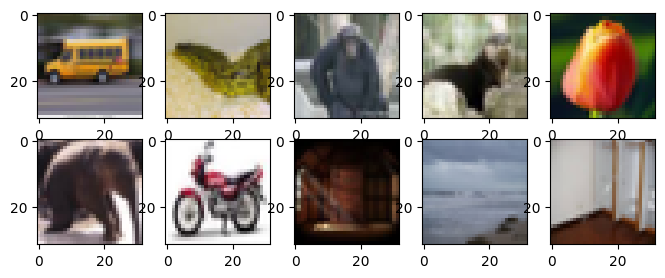

<Figure size 2000x2000 with 0 Axes>

In [55]:
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

print("\n\nShape de train_images:", train_images.shape)
print("Shape de train_labels:", train_labels.shape)
print("Shape de test_images:", test_images.shape)
print("Shape de test_labels:", test_labels.shape)

f,ax = plt.subplots(2,5,figsize=(8,3))
f = plt.figure(figsize=(20,20))
for i in range(5):
    for j in range(2):
        ax[j][i].imshow(train_images[np.random.randint(6000)])
plt.show()

## **FUNCIONES**

También, hemos creado una función llamada obtener_superclase_y_clase, en la cual se toma un número de clase como entrada y devolvemos la superclase y la clase correspondientes según el conjunto de datos que estamos manejando. Organizamos las clases en superclases utilizando diccionarios para representar esta estructura jerárquica.

Creamos otras tres funciones para hacer predicciones, mostrar las imagenes y mostrar gráficos de barras.

In [56]:
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale',
'aquarium' ,'fish', 'ray', 'shark', 'trout',
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
'bottles', 'bowls', 'cans', 'cups', 'plates',
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe',
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
'bear', 'leopard', 'lion', 'tiger', 'wolf',
'bridge', 'castle', 'house', 'road', 'skyscraper',
'cloud', 'forest', 'mountain', 'plain', 'sea',
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
'crab', 'lobster', 'snail', 'spider', 'worm',
'baby', 'boy', 'girl', 'man', 'woman',
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
'maple', 'oak', 'palm', 'pine', 'willow',
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']


def obtener_superclase_y_clase(numero_clase):


    superclases = {
        0: "aquatic_mammals",
        1: "fish",
        2: "flowers",
        3: "food_containers",
        4: "fruit_and_vegetables",
        5: "household_electrical_devices",
        6: "household_furniture",
        7: "insects",
        8: "large_carnivores",
        9: "large_man-made_outdoor_things",
        10: "large_natural_outdoor_scenes",
        11: "large_omnivores_and_herbivores",
        12: "medium_sized_mammals",
        13: "non-insect_invertebrates",
        14: "people",
        15: "reptiles",
        16: "small_mammals",
        17: "trees",
        18: "vehicles_1",
        19: "vehicles_2"
    }

    clases = {
        "aquatic_mammals": {4: 'beaver', 30: 'dolphin', 95: 'whale', 55: 'otter', 72: 'seal'},
        "fish": {1: 'aquarium_fish', 32: 'flatfish', 67: 'ray', 73: 'shark', 91: 'trout'},
        "flowers": {70: 'rose', 54: 'orchid', 62: 'poppy', 92: 'tulip', 82: 'sunflower'},
        "food_containers": {9: 'bottle', 28: 'cup', 61: 'plate', 16: 'can', 10: 'bowl'},
        "fruit_and_vegetables": {0: 'apple', 51: 'mushroom', 53: 'orange', 57: 'pear', 83: 'sweet_pepper'},
        "household_electrical_devices": {22: 'clock', 39: 'keyboard', 40: 'lamp', 86: 'telephone', 87: 'television'},
        "household_furniture": {5: 'bed', 20: 'chair', 25: 'couch', 84: 'table', 94:'wardrobe'},
        "insects": {6: 'bee', 7: 'beetle',14: 'butterfly',18: 'caterpillar', 24: 'cockroach' },
        "large_carnivores": {3: 'bear', 43: 'lion',  97: 'wolf' , 88: 'tiger', 42: 'leopard'},
        "large_man-made_outdoor_things": {12: 'bridge', 37: 'house', 17: 'castle', 68: 'road', 76: 'skyscraper'},
        "large_natural_outdoor_scenes": {23: 'cloud', 33: 'forest', 49: 'mountain', 60: 'plain', 71: 'sea'},
        "large_omnivores_and_herbivores": { 19: 'cattle', 31: 'elephant', 21: 'chimpanzee' , 38: 'kangaroo' , 15: 'camel'},
        "medium_sized_mammals": {34: 'fox' , 63: 'porcupine', 64: 'possum', 75: 'skunk' , 66: 'raccoon' },
        "non-insect_invertebrates": {26: 'crab', 45: 'lobster' , 77: 'snail', 79:'spider' , 99: 'worm' },
        "people": {11: 'boy', 35: 'girl', 46: 'man', 2: 'baby', 98: 'woman'},
        "reptiles": {27: 'crocodile', 44: 'lizard',  93: 'turtle', 78: 'snake', 29: 'dinosaur'},
        "small_mammals": {36: 'hamster', 80: 'squirrel', 50: 'mouse' , 65: 'rabbit', 74: 'shrew'},
        "trees": {47: 'maple_tree', 52: 'oak_tree', 59: 'pine_tree', 96: 'willow_tree', 56: 'palm_tree'},
        "vehicles_1": {8: 'bicycle', 48: 'motorcycle', 58: 'pickup_truck', 90: 'train', 13: 'bus'},
        "vehicles_2": {85: 'tank', 69: 'rocket', 41: 'lawn_mower', 89: 'tractor', 81: 'streetcar'}
    }

    for superclase_numero, superclase in superclases.items():
        if numero_clase in clases[superclase]:
            return superclase, clases[superclase][numero_clase]

    return None, None  # If the class number is not found

def predicciones(predictions, numeroimagen):
    # Imprimimos una lista con las probabilidades de que una imagen sea una de las 10 clases.
    # La suma de estas ha de ser uno, lo que ya se comprobó.
    print("\nLA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:")
    print(predictions[numeroimagen])

    # La variable indice_prediccion es la probabilidad más alta de la lista.
    indice_prediccion = np.argmax(predictions[numeroimagen])

    # Llamamos a la función obtener_superclase_y_clase para obtener la superclase y clase.
    superclase, clase = obtener_superclase_y_clase(indice_prediccion)

    # Imprimimos la superclase y clase obtenidas.
    print(f"\nEl modelo predice que la foto pertenece a la superclase: {superclase} y a la clase: {clase} , el índice de la clase es: {indice_prediccion}")


def plot_value_array(predictions, numeroimagen, class_names_function, label, top_n=10):
    # Obtén las etiquetas reales y predicciones para la imagen dada
    # prediction, test_label = predictions[numeroimagen],  class_names_function(np.argmax(predictions[numeroimagen]))
    prediction = predictions[numeroimagen]

    # Obtiene las n clases con las probabilidades más altas
    top_classes = np.argsort(prediction)[-top_n:][::-1]
    top_probabilities = prediction[top_classes]

    # Configura el gráfico
    plt.grid(False)

    # Utiliza la función obtener_superclase_y_clase para obtener los nombres de las clases
    class_labels = [class_names_function(i)[1] for i in top_classes]

    plt.xticks(range(len(top_classes)), class_labels, rotation='vertical')  # Mostrar nombres de clases

    # Crea el gráfico de barras con las predicciones
    thisplot = plt.bar(range(len(top_classes)), top_probabilities, color='#777777')

    # Establece el rango del eje y de 0 a 1
    plt.ylim([0, 1])

    # Marca la etiqueta predicha en rojo
    predicted_label = np.argmax(prediction)
    if predicted_label in top_classes:
        idx = np.where(top_classes == predicted_label)[0][0]
        thisplot[idx].set_color('red')

    # Si el modelo acierta, resalta la etiqueta en azul
    if label[numeroimagen][0] == predicted_label:
        idx = np.where(top_classes == predicted_label)[0][0]
        thisplot[idx].set_color('blue')

    # Añade etiquetas y título al gráfico
    plt.xlabel('Número de Clase')  # Cambiado a 'Número de Clase'
    plt.ylabel('Probabilidad')
    plt.title('Predicciones y Probabilidades')

    plt.show()




def plot_image(numeroimagen, predictions, test_labels, test_images):

    test_labels = np.array([label.item() for label in test_labels])

    prediction, test_label, test_image = predictions[numeroimagen], test_labels[numeroimagen], test_images[numeroimagen]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Mostramos la imagen de test.
    plt.imshow(test_image, cmap=plt.cm.binary)

    indice_prediccion = np.argmax(prediction)
    clase_prediccion = obtener_superclase_y_clase(indice_prediccion)

    clase_testlabel = obtener_superclase_y_clase(test_label)

    # Comprobamos si la predicción es correcta y establecemos el color de la etiqueta en consecuencia.
    if indice_prediccion == test_label:
      color = 'blue' # Si la predicción es correcta, la etiqueta se mostrará en azul.
    else:
      color = 'red' # Si la predicción es incorrecta, la etiqueta se mostrará en rojo.

    # Mostramos información de la predicción en la etiqueta
    plt.xlabel(" {} {:2.0f}% ({})".format(clase_prediccion,
                                         100*np.max(prediction),
                                         clase_testlabel),
                                         color=color)




# **2. PREPROCESAMIENTO DE DATOS.**



El preprocesamiento de datos tiene un papel muy importante en la construcción efectiva (alta precisión) de modelos de aprendizaje. Antes de mostrar los datos a la red neuronal, es esencial realizar una serie de operaciones que garanticen la calidad y la coherencia de los datos.

Este proceso involucra tareas como carga de datos, normalización, codificación de etiquetas o aumento de datos para mejorar la capacidad del modelo.

En el caso de conjuntos de datos de imágenes, como el CIFAR-100 que estamos utilizando, el preprocesamiento implica manipulaciones específicas para asegurar que las imágenes sean aptas para el entrenamiento de la red neuronal convolucional (CNN).

Esto incluye la normalización de píxeles, la codificación de las etiquetas en un formato adecuado, la generación de datos aumentados para mejorar la generalización del modelo.

In [58]:
# Convertir las etiquetas a one-hot encoding (forma binaria)
train_labelsoh = to_categorical(train_labels, 100)
test_labelsoh = to_categorical(test_labels, 100)

# Imprimir las formas de los conjuntos de entrenamiento y prueba después de la codificación one-hot
print(train_labelsoh.shape, test_labelsoh.shape)

# Normalizar las imágenes al rango [0, 1]
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255.0
test_images /= 255.0

# Obtener índices y barajar el conjunto de entrenamiento
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)
train_images_shuffled = train_images[indices]
train_labelsoh_shuffled = train_labelsoh[indices]

# Dividir el conjunto de entrenamiento en entrenamiento parcial y validación
x_val = train_images_shuffled[48000:50000]
partial_x_train = train_images_shuffled[:48000]

y_val = train_labelsoh_shuffled[48000:50000]
partial_y_train = train_labelsoh_shuffled[:48000]

# Configurar el generador de imágenes con aumentación de datos
datagen = ImageDataGenerator(
            featurewise_center=False,  # no centrar las imágenes por el conjunto de datos
            samplewise_center=False,  # no centrar cada imagen
            featurewise_std_normalization=False,  # no normalizar por la desviación estándar del conjunto de datos
            samplewise_std_normalization=False,  # no normalizar cada imagen por su desviación estándar
            zca_whitening=False,  # no aplicar blanqueo ZCA
            rotation_range=0,  # no rotar aleatoriamente las imágenes
            width_shift_range=0.1,  # desplazamiento horizontal aleatorio (fracción del ancho total)
            height_shift_range=0.1,  # desplazamiento vertical aleatorio (fracción de la altura total)
            horizontal_flip=True,  # volteo horizontal aleatorio
            vertical_flip=False)  # no voltear verticalmente las imágenes


(50000, 100) (10000, 100)


### **EXPLICACIÓN DEL PREPROCESAMIENTO.**

**1. Normalización de Píxeles:**

Todas las imágenes del conjunto de datos CIFAR-100 las transformamos al tipo de datos 'float32', lo que facilita la manipulación numérica y es común en el contexto de aprendizaje profundo.

Posteriormente, se normalizaron los valores de los píxeles dividiendo cada valor por 255.0. Esta operación asegura que los valores de los píxeles estén en el rango de 0 a 1, simplificando así el proceso de entrenamiento y mejorando la convergencia del modelo.

**2. Barajado y Separación de Conjuntos:**

Se generó un conjunto de índices y se barajaron para introducir aleatoriedad en los datos de entrenamiento. Esto ayuda a evitar sesgos y a mejorar la capacidad de generalización del modelo.

Las imágenes y las etiquetas se barajaron de acuerdo con los índices generados.
Se crearon conjuntos separados para validación (x_val e y_val) y entrenamiento parcial (partial_x_train y partial_y_train) para monitorear el rendimiento del modelo durante el entrenamiento.

**3. Aumento de Datos:**

Se empleó la clase ImageDataGenerator de Keras para aplicar aumentos de datos en tiempo real durante el entrenamiento.

Los aumentos han sido desplazamientos horizontales, desplazamientos verticales y volteos horizontales. Estas operaciones introducen variaciones y transformaciones en las imágenes de entrenamiento, mejorando así la capacidad de generalización del modelo.

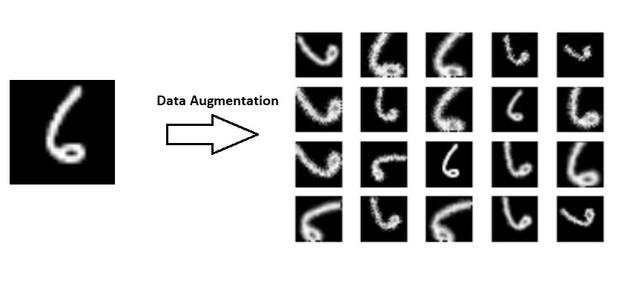

# **3. CONSTRUCCIÓN DE LOS MODELOS.**


En este último apartado se realizarán tres modelos distintos con el objetivo de clasificar las imágenes en el conjunto de datos CIFAR-100.

El primero de ellos es un modelo base, diseñado de manera simple para establecer un punto de referencia inicial.

Posteriormente, se desarrollará un segundo y tercer modelo donde se ha llevado a cabo un proceso de mejora, tomando decisiones sobre parámetros e hiperparámetros con el objetivo de alcanzar la más alta precisión posible en la tarea de clasificación.

Se investigará la arquitectura de cada modelo, detallando las capas utilizadas, los hiperparámetros seleccionados y las decisiones clave de diseño.

En el caso del segundo y tercer modelo, se destacará el proceso de ajuste y selección de parámetros realizado para maximizar la precisión de la red neuronal en la tarea específica.

Este enfoque nos permitirá comparar y contrastar los resultados obtenidos, ofreciendo una visión completa de la evolución y el perfeccionamiento de los modelos en la búsqueda de un rendimiento óptimo.

Antes de comenzar con los modelos, daremos una definición clara y breve sobre distintos conceptos que utilizaremos más tarde.

###**3.0.1 DEFINICIÓN DE CONCEPTOS NUEVOS ESENCIALES PARA NUESTROS MODELOS.**

**Maxpooling2D:**

Realiza un muestreo hacia abajo o submuestreo (reduce el número de parámetros). Permite que la detección de características sea invariante a cambios de escala u orientación. También reduce la cantidad de parámetros y cálculos en la red, y por lo tanto controla el sobreajuste.

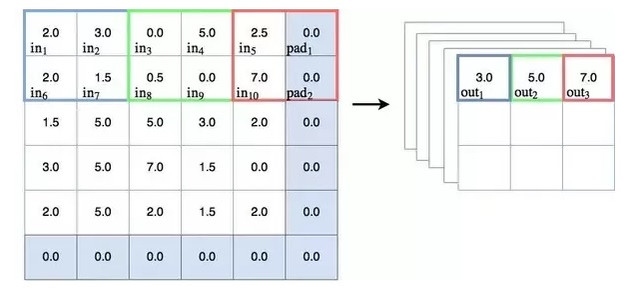

**Regularizers:**

Utilizada para reducir el sobreajuste, la regularización L2, añade un término de
penalización al coste total de la función de pérdida del
modelo que es proporcional al cuadrado de la magnitud
de los coeficientes de peso.

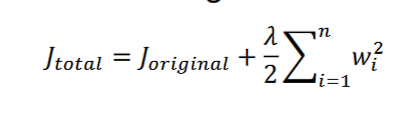

**Batch Normalization:**

Batch Normalization es una técnica utilizada en modelos de aprendizaje profundo para normalizar las activaciones de una capa, mini-batch por mini-batch, durante el entrenamiento. Esto ayuda a estabilizar y acelerar el entrenamiento, al evitar problemas como el desvanecimiento del gradiente y permitir la utilización de tasas de aprendizaje más altas. Además, Batch Normalization contribuye a hacer que el modelo sea más robusto y generalice mejor a datos no vistos.

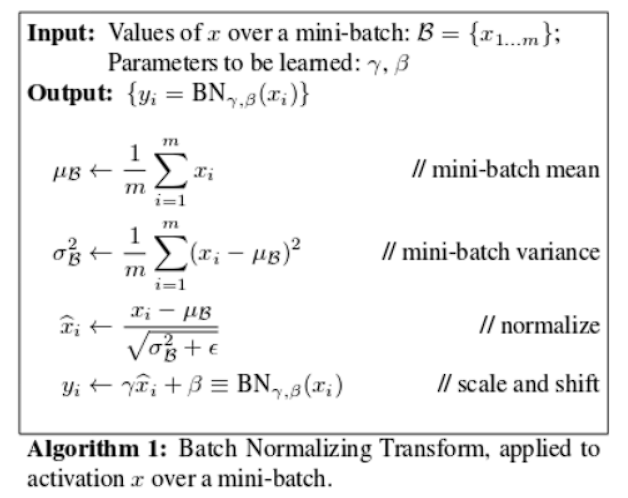


**Dropout:**
Dropout es una técnica de regularización utilizada en modelos de aprendizaje profundo para reducir el sobreajuste. Consiste en desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento, lo que ayuda a prevenir la dependencia excesiva entre neuronas y mejora la generalización del modelo.


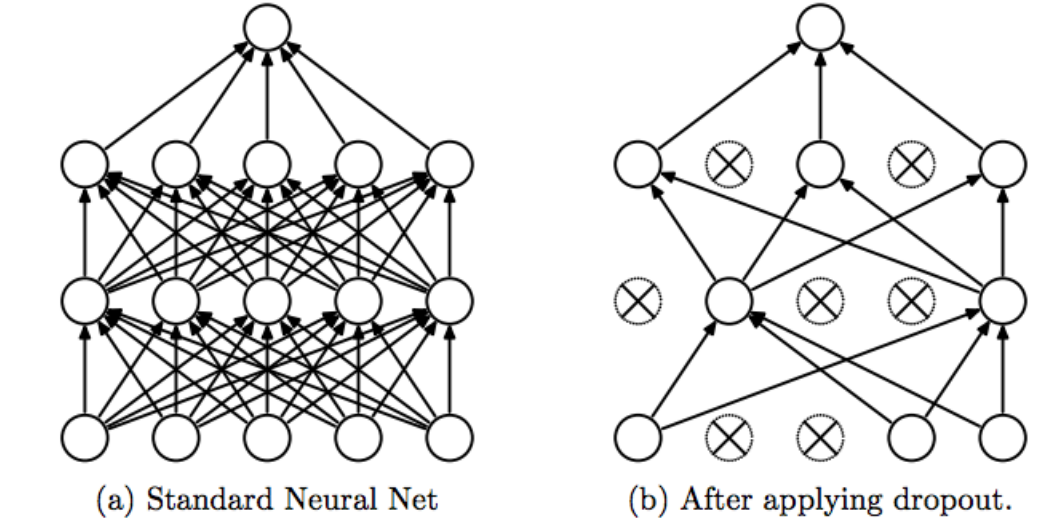

**Same Padding:**

En las capas de convolución, aplicar "same padding" significa agregar un relleno alrededor de la entrada de manera que la salida tenga el mismo tamaño que la entrada original. Esto se logra agregando ceros alrededor de los bordes de la entrada para que, después de aplicar el filtro de convolución, la salida conserve las dimensiones originales.

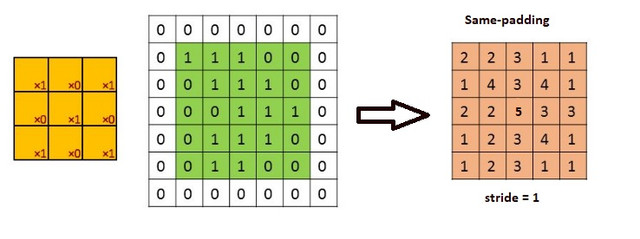

**Flattening:**

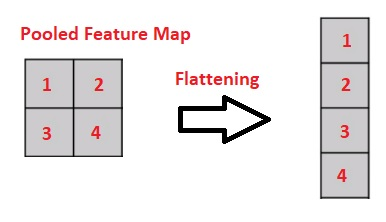

### **3.1. MODELO BÁSICO.**

Presentamos la implementación de un modelo de red neuronal convolucional (CNN) básico. El propósito fundamental de este modelo es una toma de contacto para hacer la primera clasificación de imágenes con cifar100. A continuación, se explican los elementos clave de esta estructura básica:

**Capas Convolucionales:**

*   Se han incorporado dos capas convolucionales que desempeñan un papel esencial en la detección de patrones y características visuales en las imágenes de entrada. La función de activación 'relu' se utiliza para introducir no linealidades en el aprendizaje.


**Capas de MaxPooling:**

* Después de cada capa convolucional, se ha agregado una capa de MaxPooling para reducir la dimensionalidad y preservar características fundamentales.


**Capa Flatten:**

* La capa Flatten tiene una función crucial al aplanar la salida de las capas convolucionales, preparándola para la conexión con capas densas.

**Capa Densa (Totalmente Conectada):**

* La última capa densa, con activación 'softmax', realiza la clasificación en 100 categorías, correspondientes a las etiquetas del conjunto de datos.
Compilación y Entrenamiento:

El modelo se entrena con pérdida de entropía cruzada categórica, optimizador RMSprop y la métrica de precisión.

Durante el entrenamiento, se aplican técnicas de aumento de datos utilizando un generador de flujo de datos para mejorar la generalización del modelo.


In [7]:
model1 = Sequential()

model1.add(Conv2D( 32, (5,5) , activation = 'relu', input_shape= ( 32,32,3 )))

model1.add(MaxPooling2D((2,2)))

model1.add(Conv2D(64, (5,5), activation = 'relu'))

model1.add(MaxPooling2D((2,2)))

model1.add(Flatten())

model1.add(Dense(100, activation='softmax'))

model1.summary()

model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history1 = model1.fit(datagen.flow(partial_x_train, partial_y_train, batch_size=400),
                    epochs=30,
                    validation_data=(x_val, y_val),
                    verbose=1)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 100)               1

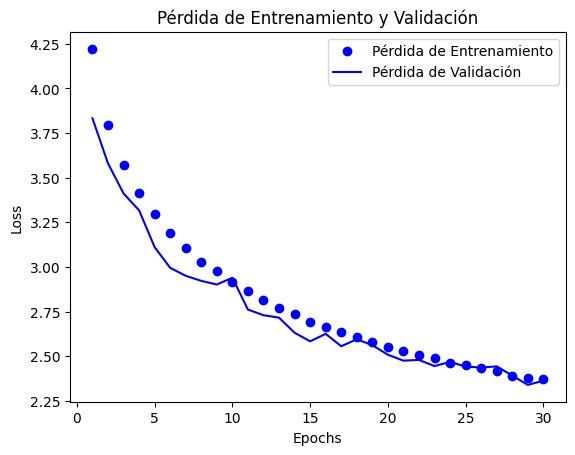

In [8]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azul"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

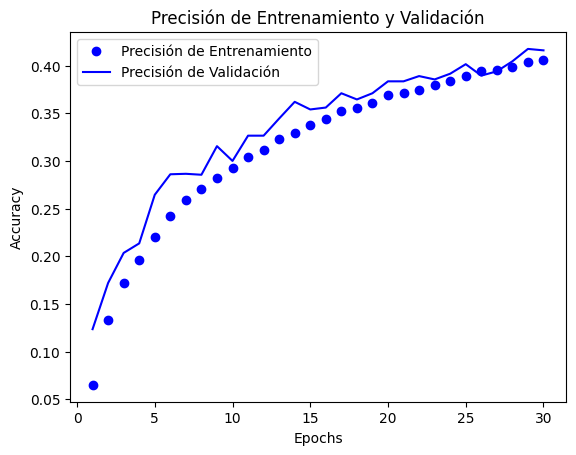

In [9]:
plt.clf()   # Limpia la figura
acc_values = history1.history['accuracy']
val_acc_values = history1.history['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc_values, 'b', label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

####**3.1.1 EXPLICACIÓN CÁLCULO NÚMERO PARÁMETROS**

Vemos que nuestro primer módelo tiene **213.796** parámetros totales.

A continuación, explicaremos el cálculo de estos parámetros.

**Capa Conv2D (32 filtros):**

Tamaño del Kernel = 5×5

Canales de Entrada = 3 (imagen en color)

Número de Filtros = 32

Parámetros = (5×5×3+1)×32=2432

**Capa Conv2D (64 filtros):**

Tamaño del Kernel = 5×5

Canales de Entrada = 32 (salida de la capa anterior)

Número de Filtros = 64

Parámetros = (5×5×32+1)×64=51264

**Capa Dense (Total de 100 clases en la salida):**

Tamaño de Entrada = 5×5×64 (la salida de la última capa convolucional)

Parámetros = (5×5×64+1)×100=160100

Entonces, el **número total de parámetros** para nuestro primer modelo básico es la suma de los parámetros de cada capa:

**2432+51264+160100=213796**

#### **3.1.2 GRÁFICOS PERDIDA / PRECISIÓN DURANTE ENTRENAMIENTO**



####**Grafico 1: Pérdida de Entrenamiento y Validación**
Pérdida de Entrenamiento (blue dots): Representa cómo la pérdida en el conjunto de entrenamiento disminuye a medida que avanzan las épocas.

Pérdida de Validación (blue line): Muestra cómo la pérdida en el conjunto de validación se comporta a lo largo del entrenamiento.

Observaciones:

Ambas curvas (entrenamiento y validación) muestran una disminución en la pérdida a lo largo de las épocas.

No hay indicios de sobreajuste (overfitting), ya que las curvas de entrenamiento y validación siguen trayectorias similares.


####**Grafico 2: Precisión de Entrenamiento y Validación**

Precisión de Entrenamiento (blue dots): Muestra cómo la precisión en el conjunto de entrenamiento aumenta con las épocas.

Precisión de Validación (blue line): Representa cómo la precisión en el conjunto de validación evoluciona durante el entrenamiento.

Observaciones:

Ambas curvas (entrenamiento y validación) muestran un aumento en la precisión a medida que se incrementan las épocas.
No hay indicios de sobreajuste, ya que las curvas de entrenamiento y validación siguen trayectorias similares.


####**Elección de Época**


Dado que estamos interesados en elegir la mejor época, podemos observar que en la época 29, tanto la pérdida de validación como la precisión de validación alcanzan los valores más bajos y altos, respectivamente.

Por lo tanto, la época 29 es una elección razonable para seleccionar el modelo final, ya que presenta un buen equilibrio entre bajo error y alta precisión en el conjunto de validación.







####**3.1.3 ENTRENAMIENTO DEL MODELO CON DATOS DE TEST**

Como ya hemos comentado en el apartado anterior, entrenaremos nuestro modelo con los datos del conjunto de test 29 épocas.

Los resultados deben ser muy parecidos a los obtenidos con el conjunto de validación en la época 29.

Entrenemos ahora una nueva red desde cero durante 29 épocas, luego la evaluaremos con el conjunto de test:


In [11]:
model2 = Sequential()

model2.add(Conv2D( 32, (5,5) , activation = 'relu', input_shape= ( 32,32,3 )))

model2.add(MaxPooling2D((2,2)))

model2.add(Conv2D(64, (5,5), activation = 'relu'))

model2.add(MaxPooling2D((2,2)))

model2.add(Flatten())

model2.add(Dense(100, activation='softmax'))


model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history2 = model2.fit(datagen.flow(train_images_shuffled, train_labelsoh_shuffled, batch_size=400),
                      epochs=29,
                      verbose=1)

test_loss, test_acc = model2.evaluate(test_images, test_labelsoh)

Epoch 1/29
125/125 [==============================] - 25s 186ms/step - loss: 4.2013 - accuracy: 0.0673
Epoch 2/29
125/125 [==============================] - 24s 188ms/step - loss: 3.7645 - accuracy: 0.1372
Epoch 3/29
125/125 [==============================] - 24s 194ms/step - loss: 3.5263 - accuracy: 0.1782
Epoch 4/29
125/125 [==============================] - 25s 203ms/step - loss: 3.3625 - accuracy: 0.2084
Epoch 5/29
125/125 [==============================] - 24s 189ms/step - loss: 3.2275 - accuracy: 0.2342
Epoch 6/29
125/125 [==============================] - 25s 196ms/step - loss: 3.1321 - accuracy: 0.2539
Epoch 7/29
125/125 [==============================] - 24s 188ms/step - loss: 3.0505 - accuracy: 0.2674
Epoch 8/29
125/125 [==============================] - 24s 196ms/step - loss: 2.9733 - accuracy: 0.2825
Epoch 9/29
125/125 [==============================] - 25s 196ms/step - loss: 2.9059 - accuracy: 0.2991
Epoch 10/29
125/125 [==============================] - 23s 187ms/step - l

In [12]:
test_loss, test_acc

(2.411982297897339, 0.40700000524520874)

#### **3.1.4 MATRIZ DE CONFUSIÓN MODELO BÁSICO Y OTRAS PREDICCIONES**

313/313 [==============================] - 1s 3ms/step


========================== IMAGEN Nº4452 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[6.60859150e-05 8.80625885e-05 1.80549128e-03 1.11746695e-02
 1.43607914e-01 1.96893845e-04 4.39527594e-02 1.12948999e-01
 2.25662952e-03 8.27205658e-04 1.98716577e-03 3.94929852e-03
 1.97907037e-04 3.25350629e-05 2.42720712e-02 7.93017354e-03
 2.26046774e-03 4.82762262e-05 8.02925602e-03 5.17551601e-03
 2.70620891e-04 9.46350023e-03 2.05341913e-03 6.16456759e-07
 6.07110001e-02 1.28847209e-03 2.71591614e-03 2.83843279e-03
 7.58221198e-04 1.95562281e-03 2.56196217e-04 7.33379880e-03
 5.48128854e-04 1.04888139e-04 4.41342732e-03 4.61698230e-03
 2.12814752e-03 6.40276528e-04 1.61962472e-02 1.12475551e-04
 5.02905925e-04 1.25766243e-03 4.56871418e-03 2.94472035e-02
 6.94418373e-03 4.50958731e-03 2.77055521e-03 4.84061384e-05
 5.31690486e-04 4.42050805e-07 7.42976740e-02 1.27212508e-04
 4.80620656e-05 9.45782813e-

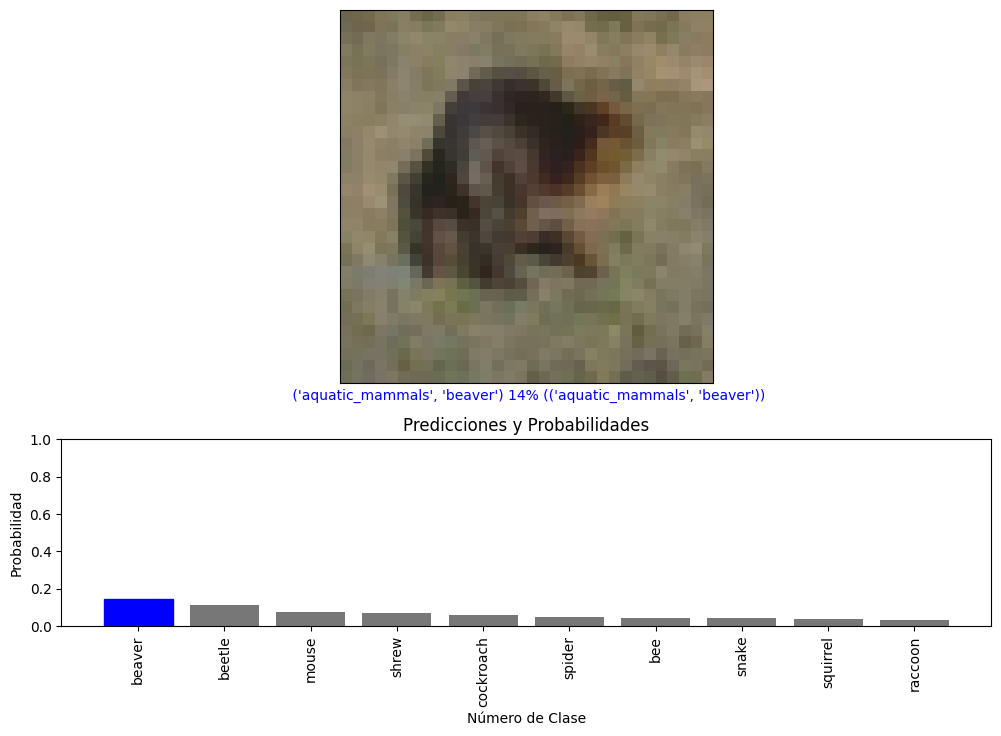

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº7880 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[5.61925699e-05 6.12910117e-06 1.64739531e-03 6.67076674e-05
 5.91864700e-05 5.66394022e-03 1.54338113e-03 1.22981670e-04
 2.95592509e-02 8.60302448e-02 1.65244855e-04 5.14923269e-03
 6.89854845e-03 4.03454667e-03 2.89385067e-03 4.02325066e-03
 6.76787633e-04 1.26611919e-03 4.83822543e-03 1.11964282e-05
 1.96607853e-03 1.71550419e-04 1.08313642e-03 6.16307352e-06
 2.49193727e-05 2.63837632e-03 1.68696308e-04 4.52623906e-04
 7.78338381e-06 6.03197049e-03 3.89474764e-07 1.63441146e-05
 2.26408662e-03 6.28823601e-03 8.02702471e-06 4.88638505e-03
 1.06734615e-05 9.20409709e-03 1.56340830e-05 6.88877190e-05
 3.93354660e-03 5.86128347e-02 1.12675159e-04 6.65263578e-05
 4.74340995e-05 3.84843303e-03 1.10477805e-02 1.13845419e-03
 9.11584962e-03 9.71770351e-06 4.72083666e-05 1.51383472e-04
 2.43819645e-03 1.85665523e-03 2.87644856e-04 3.33987176e-04
 9.22921766e-03 3.0221

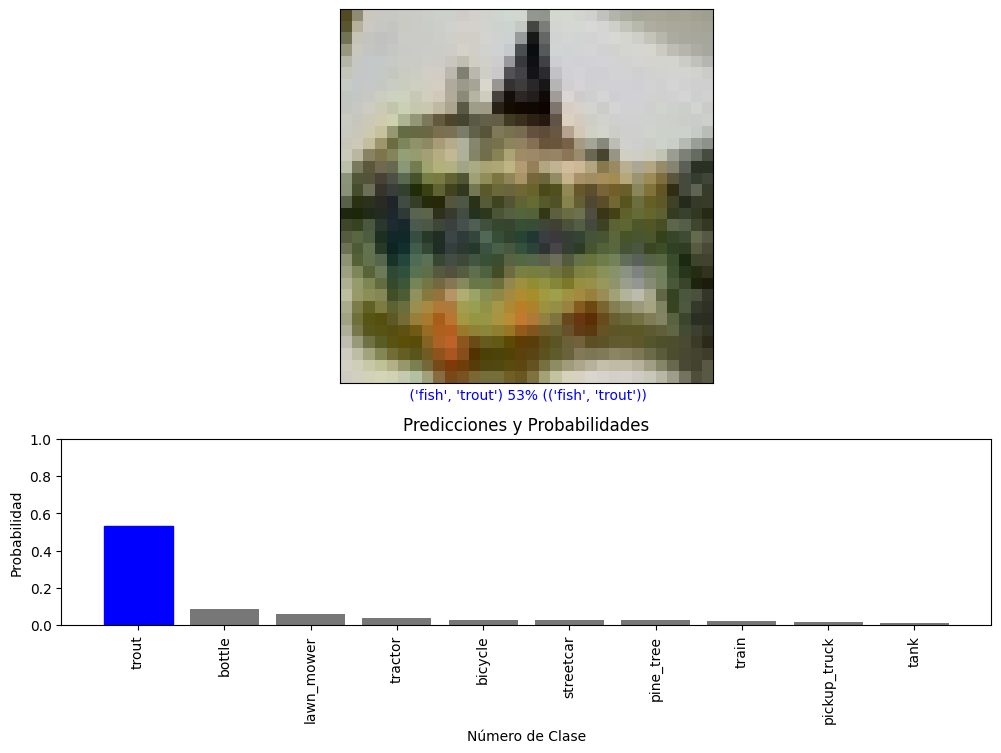

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº5404 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[4.2527485e-05 9.2616956e-06 2.9005166e-04 9.0091885e-04 6.6335889e-04
 4.5745019e-03 8.5134134e-03 5.6048419e-02 1.3700875e-02 3.1366684e-03
 6.7302538e-03 4.0044831e-03 1.6156351e-03 1.4493819e-03 4.2063990e-03
 3.8205434e-03 6.0969044e-02 2.9162416e-05 3.0564764e-04 2.9482297e-03
 4.7896660e-04 2.3330336e-03 3.7540201e-02 6.9235831e-08 3.3690846e-03
 2.7316171e-03 2.1580255e-02 5.1079848e-04 7.0250044e-03 6.4155547e-04
 2.2358140e-06 1.4968398e-03 8.9827302e-04 1.7055008e-03 3.0116568e-04
 3.0709645e-03 3.4231434e-04 6.8184715e-03 1.3674032e-03 1.2905726e-02
 2.5274365e-03 5.2999781e-04 7.5804838e-03 2.1535137e-03 4.7938493e-03
 9.5104864e-03 1.2718885e-03 8.6951710e-05 4.2267803e-02 7.7616846e-09
 2.4664646e-03 1.7580012e-04 1.3693121e-05 1.5404608e-05 2.4765264e-05
 1.5111860e-03 1.7506964e-04 3.9451054e-04 1.1825652e-03 3.2585833e-04
 1.8427073e-07 5.8543112

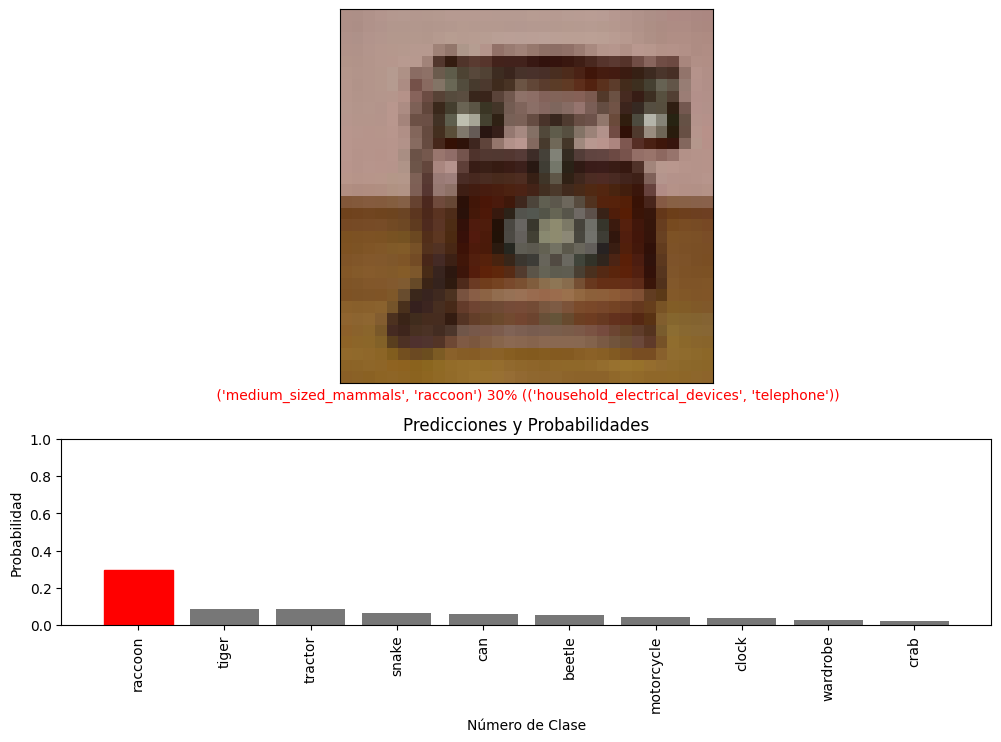

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº5447 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[8.81089736e-03 3.68758651e-06 1.15365963e-02 3.74792865e-03
 1.49875472e-03 1.04436942e-03 9.42708633e-04 6.23081636e-04
 1.67232624e-03 6.96263229e-03 1.97189637e-02 1.03703015e-01
 7.95892629e-05 5.44647301e-05 2.37213983e-03 2.50121187e-02
 1.62538946e-01 1.16169591e-04 6.76897180e-04 7.86565915e-02
 4.44582058e-03 5.08795027e-03 4.39312235e-02 9.70345354e-07
 7.33395631e-04 9.49957874e-03 4.46425937e-03 4.27145642e-05
 3.69230956e-02 1.18257024e-03 2.04983444e-05 5.63792251e-02
 7.74459913e-02 1.42639092e-05 2.57665804e-03 4.35301103e-02
 9.49175470e-03 1.14012670e-04 9.58660338e-03 4.48725792e-03
 6.54302118e-03 1.85130019e-04 1.21685781e-03 1.96344731e-03
 3.56306229e-03 8.29075056e-04 5.96472286e-02 1.09941175e-05
 1.80429066e-04 1.06293015e-07 6.54275902e-03 1.74401933e-03
 1.21751938e-07 9.23922780e-05 9.70904133e-04 3.61676421e-03
 1.15295465e-04 4.1296

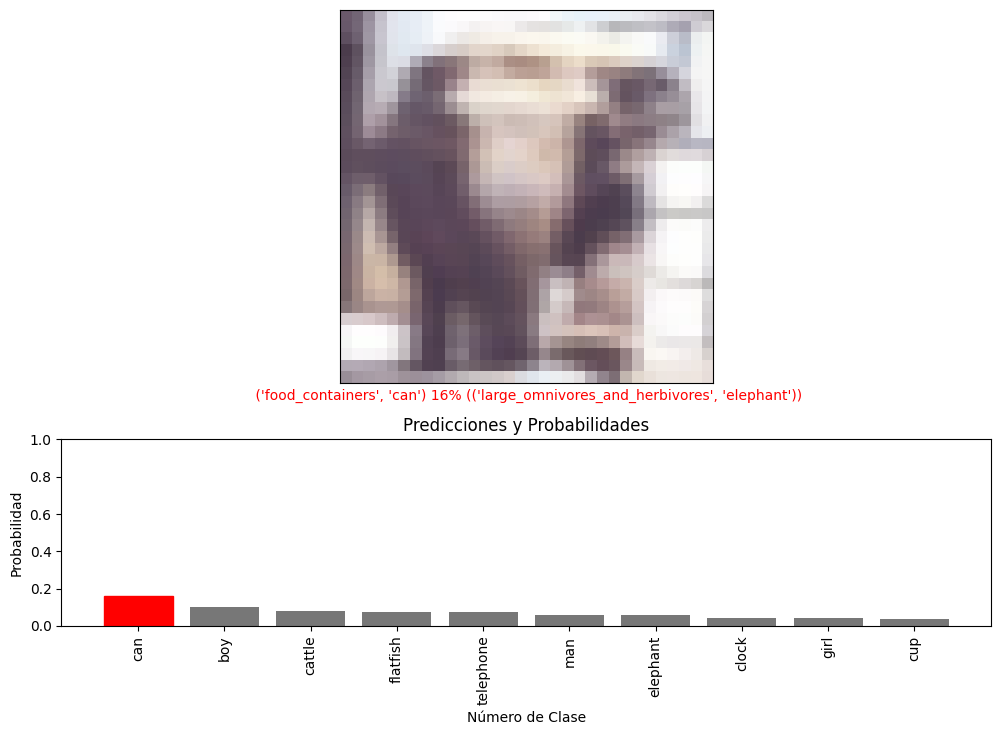

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº7390 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[2.8123270e-05 2.2117323e-05 3.0623761e-04 2.5576830e-03 2.9556491e-04
 9.8240259e-04 1.3063707e-04 1.1814633e-02 3.0356596e-04 7.7985921e-03
 3.1661894e-02 7.3904305e-04 3.7328409e-05 3.9507154e-02 5.0770319e-03
 9.6113770e-05 3.3069658e-03 4.6859469e-08 1.3372103e-04 2.7135457e-03
 2.1168243e-04 2.1800317e-01 3.5106301e-02 6.3131395e-08 2.0952415e-04
 3.4817243e-03 3.8963056e-03 3.1192283e-04 5.0527719e-04 8.0615602e-05
 2.0349411e-05 4.4970808e-04 1.2513724e-03 1.0029746e-05 1.0789077e-05
 2.5062653e-04 3.5030409e-06 3.3516353e-05 2.4266770e-05 3.5409831e-02
 3.1606308e-03 4.0601209e-02 2.8557755e-05 4.1349745e-06 3.5039451e-05
 3.1817222e-03 5.6902375e-03 6.3475331e-06 1.6941736e-02 1.7206909e-07
 9.5496493e-05 3.5300956e-04 1.1813619e-06 2.2720064e-06 1.2285257e-05
 6.6359562e-04 1.7019692e-06 3.2007032e-05 3.3480671e-01 3.3448658e-05
 8.7783775e-10 2.2444699

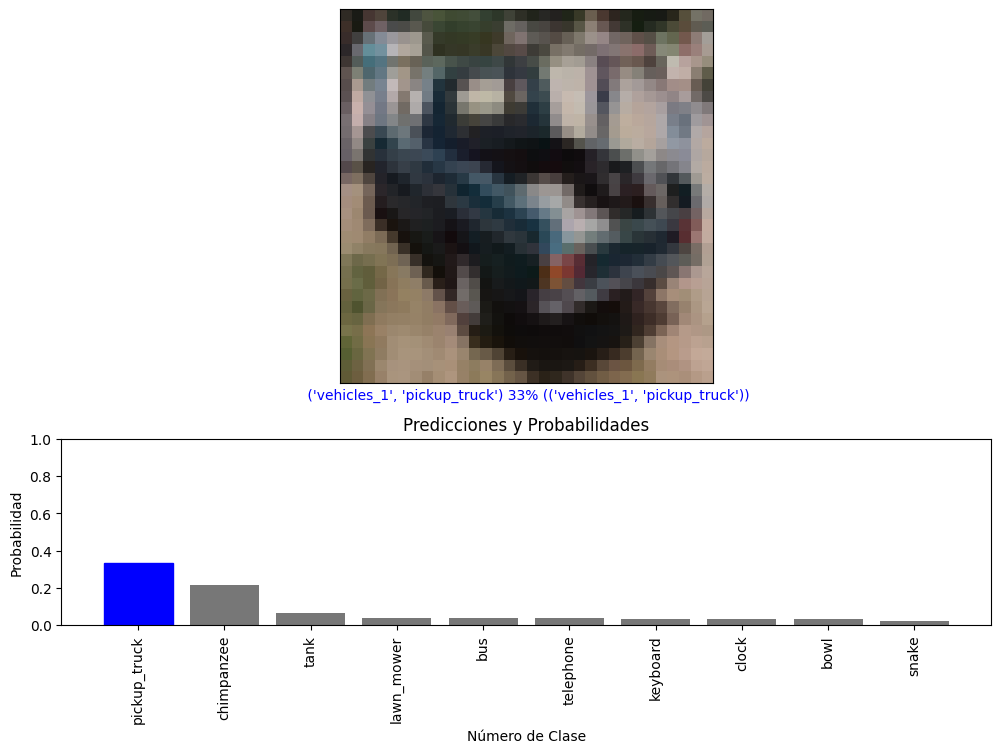

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº2658 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[1.1106634e-03 2.7984239e-03 7.6750889e-03 3.1248210e-02 3.6301436e-03
 2.3125825e-04 2.3457188e-02 7.2229011e-03 1.1373995e-02 5.0432244e-03
 5.1466742e-04 1.6924139e-02 1.7850222e-04 7.7441015e-04 8.4895037e-02
 2.2133726e-03 6.6540227e-03 1.4937150e-06 2.6406441e-04 2.0320851e-03
 3.7707057e-04 1.9608122e-01 1.4788456e-03 3.5145153e-05 2.1690749e-04
 5.8917172e-04 4.8473277e-04 5.2591960e-04 5.2821399e-03 9.3469088e-04
 6.2666897e-04 7.2866738e-02 8.7622053e-04 2.7637542e-03 2.7236009e-03
 5.4380377e-03 3.1085976e-04 5.9170445e-04 1.9100381e-03 2.6654826e-02
 4.7978163e-03 9.7735999e-03 5.8385157e-03 2.1808285e-03 9.8028407e-04
 1.5269867e-02 2.0218690e-01 1.2887821e-04 5.5029776e-02 6.1927436e-05
 4.6063121e-03 9.7664678e-04 5.4272432e-06 1.3874561e-04 8.0333237e-04
 3.4054655e-03 5.1326635e-05 1.5313725e-03 3.1781201e-03 7.6836281e-05
 1.1527525e-07 2.9090501

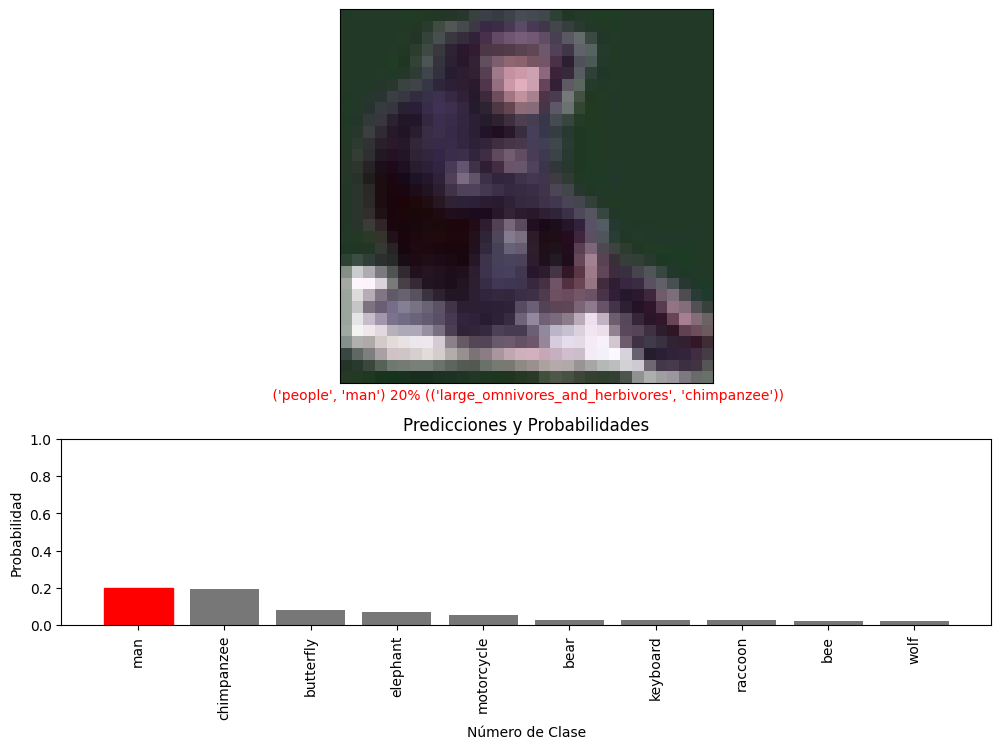

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº400 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[3.8185080e-06 3.9074798e-03 3.3639662e-05 5.5080657e-03 9.6413968e-03
 2.1098970e-04 5.2821827e-07 8.7704448e-06 6.8044006e-05 8.7334285e-04
 2.9300132e-03 1.5109676e-04 4.5872577e-05 1.8272294e-03 1.4647501e-05
 7.2518899e-04 4.9197691e-04 2.5035872e-04 6.7333087e-07 3.6090388e-04
 1.2587915e-04 5.8746364e-02 1.8963765e-02 1.8206732e-05 1.6130909e-06
 2.3314666e-02 3.5393263e-05 4.1429736e-03 6.4844784e-04 1.3982697e-04
 8.5215986e-02 1.9973743e-04 1.6169707e-04 1.6993190e-04 1.3142294e-04
 1.2663209e-05 1.5635732e-04 8.1449589e-03 7.2924158e-05 5.5653662e-03
 1.7316507e-02 8.8403664e-05 2.8166740e-04 7.0729882e-05 1.5870777e-05
 1.1378248e-03 3.6139018e-04 1.1184493e-02 6.6571712e-04 5.1881545e-03
 2.5478692e-03 2.9835368e-07 1.2530460e-02 3.4806115e-07 9.5006504e-07
 3.3274684e-03 3.2202151e-05 1.4559317e-05 1.1963462e-03 1.1039498e-03
 1.3042221e-06 6.5773417e

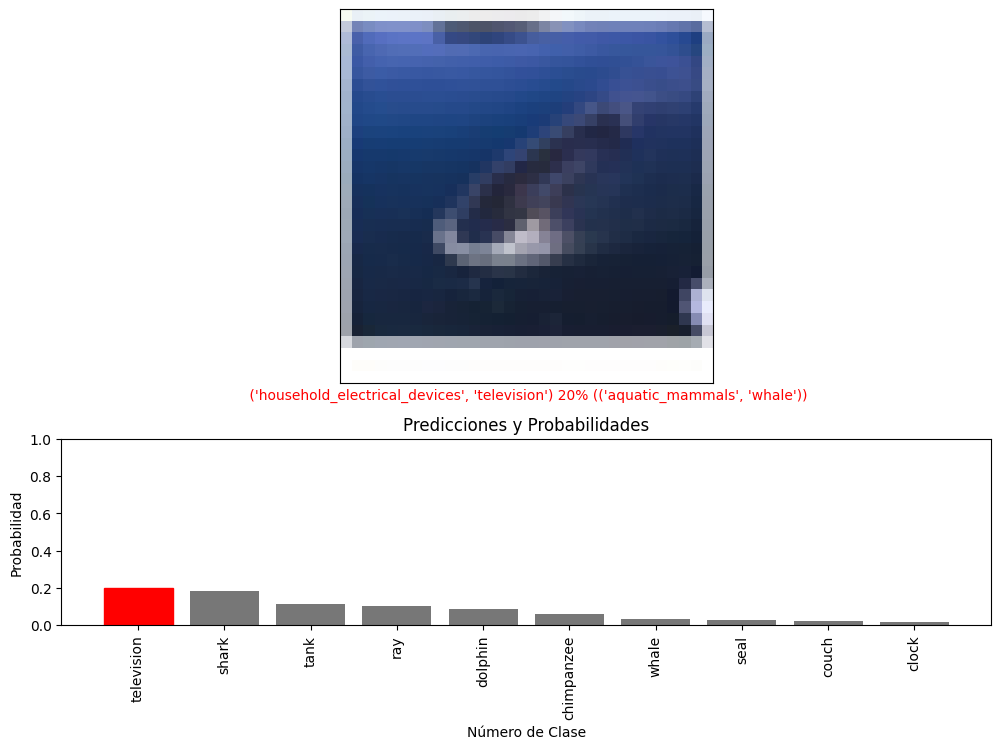

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº8195 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[4.70477249e-03 2.05794419e-03 1.62593822e-03 7.68077953e-05
 2.98328727e-04 7.53781851e-03 4.56875637e-02 3.15279607e-03
 1.38857132e-02 1.72696397e-01 3.43942689e-03 6.80433004e-04
 7.53054337e-04 9.00360174e-04 2.48865946e-03 4.42956528e-03
 7.79842446e-03 4.28669213e-04 2.78144293e-02 4.41391807e-04
 9.93451802e-04 4.23425035e-06 3.15971347e-03 5.89373303e-05
 2.80867127e-04 2.69923056e-03 3.49692826e-04 1.64673675e-03
 1.15168747e-04 5.54534234e-03 6.77947673e-06 1.44739432e-04
 1.21155623e-02 1.70108918e-02 1.20184047e-03 2.29025679e-03
 2.97620147e-03 4.73843364e-04 9.78404307e-04 4.46266989e-04
 3.11505492e-03 9.26315028e-04 9.53187235e-04 1.23621104e-02
 1.14746718e-03 1.20836613e-03 2.66406639e-03 6.16874732e-02
 3.90189998e-05 3.97525509e-05 3.13903764e-03 1.58516830e-03
 1.84178632e-03 1.67402644e-02 1.30874841e-02 1.79335207e-03
 6.60505658e-03 1.1647

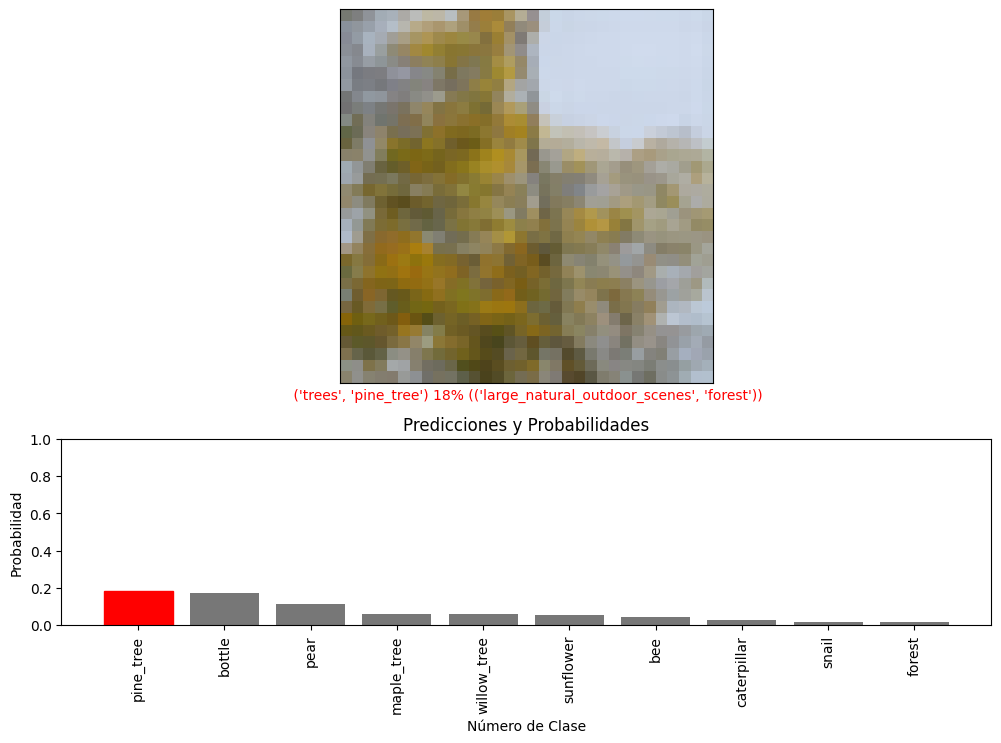

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº8144 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[8.0641749e-04 3.1507565e-04 6.3963869e-04 2.1753451e-03 5.6666988e-03
 2.7592408e-03 1.7385799e-02 1.6718986e-03 1.9769877e-02 7.8960555e-03
 1.0980018e-02 5.5761670e-04 2.3790916e-04 5.9348135e-06 1.4903723e-03
 5.6794863e-02 4.6622506e-03 6.4101088e-04 6.2893196e-03 4.5499131e-03
 1.6436803e-03 1.0071090e-05 3.2774188e-02 7.2375333e-05 3.0041672e-03
 6.3725961e-03 9.3009183e-03 3.0460183e-03 5.4630572e-03 8.5034538e-03
 4.4752373e-06 1.1861626e-02 2.6681090e-03 2.3957694e-02 1.6401578e-02
 7.9656043e-04 3.7091300e-02 9.0995902e-04 2.3721591e-02 1.3349937e-02
 1.8695791e-03 6.1342512e-06 2.8001238e-02 9.5674075e-02 1.3773552e-02
 6.5667313e-03 3.1533296e-04 1.1515853e-02 3.7983964e-06 1.8894995e-06
 1.1505343e-01 1.7680692e-03 1.8160934e-04 1.4827818e-03 1.5485527e-03
 3.3154113e-03 1.8807846e-03 1.8144853e-02 1.3340747e-06 2.0390255e-03
 5.8282913e-05 2.5068175

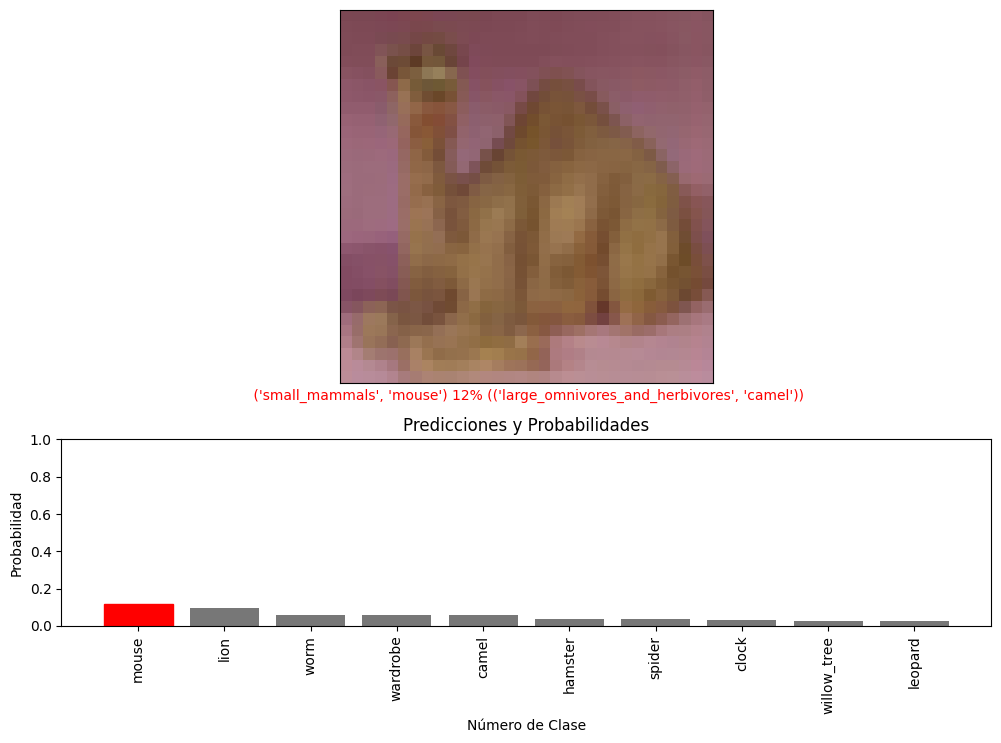

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº2753 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[9.24771186e-03 1.47565486e-04 7.40207834e-05 1.39529902e-06
 5.53364465e-08 1.15785888e-05 3.30138323e-06 5.35683171e-07
 8.00026767e-10 5.07614232e-06 2.03687945e-04 5.38655149e-04
 1.70956912e-06 4.02038092e-09 7.48334860e-05 1.58349303e-05
 5.53226018e-05 6.13353279e-08 1.52137511e-06 7.32021235e-08
 2.98301586e-07 3.11080987e-11 1.02874954e-04 4.01265865e-09
 2.25251597e-06 3.70159319e-06 1.04003220e-05 7.10882265e-12
 1.61173084e-05 4.08998130e-06 3.71994519e-10 1.83801835e-10
 1.21825606e-05 1.42594020e-10 1.24905791e-05 7.53245607e-04
 5.45364514e-04 8.40435543e-09 6.99768732e-09 2.16914007e-08
 2.07524071e-03 2.16891678e-08 1.66283307e-08 3.17142303e-06
 7.29134399e-07 1.73478347e-05 2.10253420e-05 3.39776562e-09
 2.52097121e-10 3.48879947e-09 4.34719095e-06 2.96727603e-06
 2.33694639e-12 9.48545992e-01 2.47947555e-05 1.36937450e-09
 9.29794819e-09 2.0694

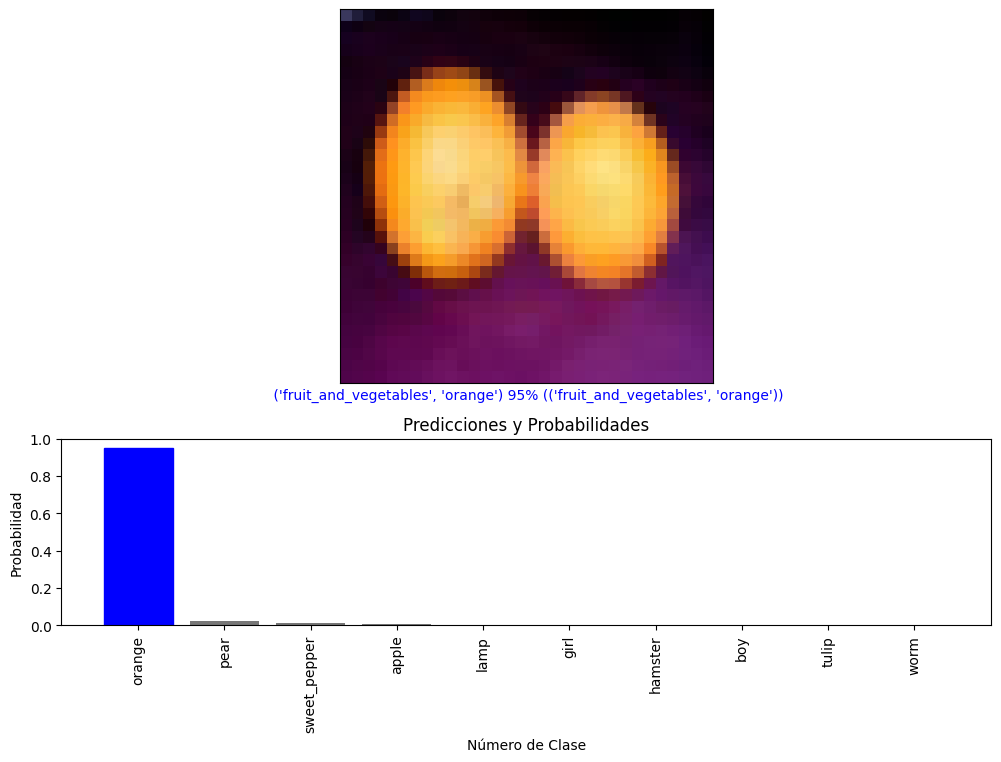

<Figure size 640x480 with 0 Axes>

In [13]:
predictions = model2.predict(test_images)
# Obtén índices aleatorios del conjunto de datos de prueba
indices_aleatorios = random.sample(range(len(test_images)), 10)

for k, indice in enumerate(indices_aleatorios):
    print("\n\n=================================================================")
    print(f"========================== IMAGEN Nº{indice+1} ===========================")

    # Predicciones
    predicciones(predictions, indice)

    # Crear la figura con una cuadrícula personalizada de 2 filas y 2 columnas
    plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

    # Subgráfico 1: Mostrar la imagen y la etiqueta
    ax0 = plt.subplot(gs[0, :])
    plot_image(indice, predictions, test_labels, test_images)

    # Subgráfico 2: Mostrar el array de valores
    test_labels2 = test_labels
    ax1 = plt.subplot(gs[1, :])
    plot_value_array(predictions, indice, obtener_superclase_y_clase,test_labels2)

    # Ajustar el diseño de los subgráficos
    plt.tight_layout()

    # Mostrar la figura
    plt.show()


####**3.1.5 OTRAS CONSIDERACIONES SOBRE EL MODELO**

Este modelo nos ha servido para saber el alcance que tiene y detectar posibles áreas de mejora que implementaremos en el siguiente modelo.

### **3.2. MODELO AVANZADO.**

**ReduceLearningRateExponential: Explicación y Utilidad**

La clase ReduceLearningRateExponential es una implementación personalizada de un callback, específicamente diseñado para ajustar el learning rate de manera exponencial durante el entrenamiento de una red neuronal.

**Funcionalidad:**

**Reducción Exponencial del Learning Rate:**

Después de un número específico de épocas (determinado por start_epoch y frequency), esta callback reduce el learning rate de la red multiplicándolo por un factor (factor). Esta reducción sigue una función exponencial, disminuyendo el learning rate de manera más agresiva en comparación con métodos lineales.

**Utilidad:**

**Evitar Mínimos Locales y Acelerar la Convergencia:**

El uso de learning rates adaptativos, como el implementado por esta callback, puede ayudar a evitar mínimos locales subóptimos durante el entrenamiento. Una tasa de aprendizaje que es demasiado grande puede llevar a oscilaciones o incluso a la divergencia, mientras que una tasa de aprendizaje demasiado pequeña puede hacer que el modelo converja lentamente y quede atrapado en mínimos locales no deseados. La reducción exponencial permite una disminución rápida del learning rate inicial, seguida de ajustes más finos a medida que avanza el entrenamiento.

In [21]:
from keras.callbacks import Callback
from keras import backend as K

class ReduceLearningRateExponential(Callback):
    def __init__(self, factor=0.8, start_epoch=15, frequency=4, min_lr=1e-6):
        super(ReduceLearningRateExponential, self).__init__()
        self.factor = factor
        self.start_epoch = start_epoch
        self.frequency = frequency
        self.min_lr = min_lr

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if epoch >= self.start_epoch and (epoch - self.start_epoch) % self.frequency == 0:
            old_lr = float(K.get_value(self.model.optimizer.lr))
            new_lr = old_lr * self.factor
            new_lr = max(new_lr, self.min_lr)
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f'\nEpoch {epoch + 1}: Reducing learning rate to {new_lr}')



#### **Explicación Detallada del Modelo y sus Hiperparámetros:**

**Arquitectura de la Red:**

Capas Convolucionales:

**Capa 1 (Conv2D - 128 filtros):**

Utiliza 128 filtros con kernel (3,3) y función de activación 'elu'.
Se aplica MaxPooling para reducir dimensionalidad.
Se agrega regularización L2 para controlar el sobreajuste.

**Capa 2 (Conv2D - 128 filtros):**

Otra capa convolucional similar para capturar características más complejas.

**Capa 3 (Conv2D - 256 filtros):**

Aumenta la complejidad con 256 filtros, seguido de MaxPooling.

**Capa 4 (Conv2D - 512 filtros):**

Añade mayor capacidad de representación con 512 filtros antes del último MaxPooling.
Incluye Dropout para reducir el sobreajuste.

**Capas Densas:**

**Densa 1 (1024 unidades, activación 'elu'):**

Capa completamente conectada con 1024 unidades y activación 'elu'.
Dropout para regularización y evitar el sobreajuste.

**Densa de Salida (100 unidades, activación 'softmax'):**

Capa de salida con 100 unidades (número de clases) y activación 'softmax'.

Hiperparámetros:

**Dropout (0.30):**

Introducido en varias capas para prevenir el sobreajuste durante el entrenamiento.
Elimina aleatoriamente conexiones neuronales, mejorando la generalización.

**Learning Rate Exponencial:**

Se implementa un learning rate que disminuye exponencialmente después de la época 15.
Ayuda a mejorar la convergencia y evitar mínimos locales subóptimos.

**Batch Size (225):**

Tamaño de lote elegido para mejorar la eficiencia computacional durante el entrenamiento.

**Justificación de Decisiones:**

**Capas Convolucionales:**

Se eligen filtros de tamaños progresivamente mayores para capturar características jerárquicas.
La regularización L2 ayuda a controlar la complejidad del modelo.

**Capas Densas y Dropout:**

Se utilizan para construir una representación más profunda y compleja.
Dropout minimiza el sobreajuste al desactivar conexiones de manera aleatoria.

**Learning Rate Exponencial:**

Optimiza la convergencia del modelo ajustando dinámicamente el learning rate.

Hemos decidido no usar **Batch Normalization** por dos motivos:

**Redes Pequeñas:**

En redes más pequeñas o menos profundas, los beneficios de Batch Normalization no son muy pronunciados.

**Efectos de Regularización:**

Aunque Batch Normalization tiene un efecto de regularización incorporado, en algunos casos, puede no ser necesario o incluso perjudicial si ya se están utilizando otras técnicas de regularización, como Dropout.

In [23]:
reduce_lr_exponential = ReduceLearningRateExponential(factor=0.8, start_epoch=15, frequency=4, min_lr=1e-6)


model = Sequential()

model.add(Conv2D(128, (3,3), activation='elu', input_shape=(32,32,3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))


model.add(Conv2D(256, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(512, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))


model.add(Flatten())


model.add(Dense(1024, activation='elu'))
model.add(Dropout(0.30))

model.add(Dense(100, activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



# Entrenar el modelo con el callback
history2 = model.fit(datagen.flow(partial_x_train, partial_y_train, batch_size=225),
                    epochs=120,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[reduce_lr_exponential])



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 8, 8, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 8, 8, 256)        

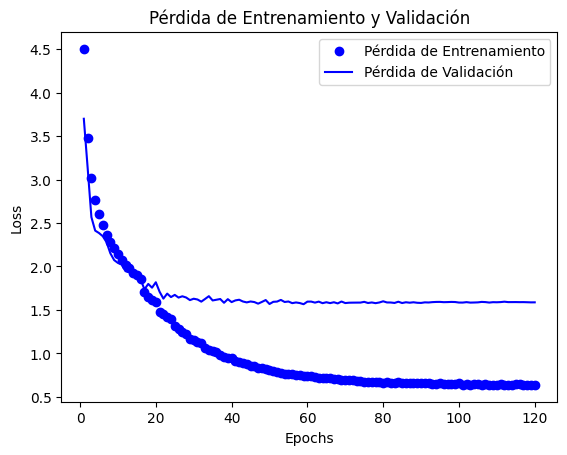

In [24]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azul"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

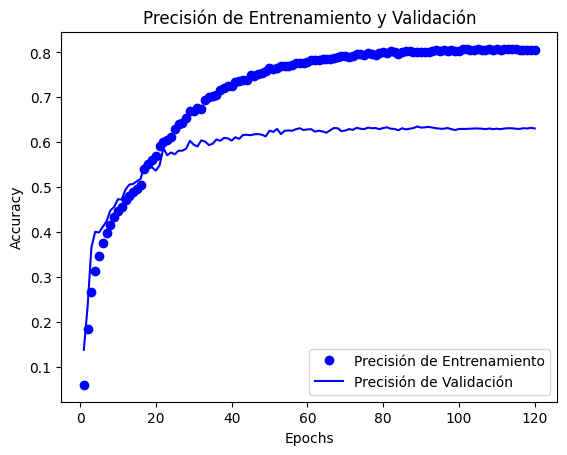

In [25]:
plt.clf()   # Limpia la figura
acc_values = history2.history['accuracy']
val_acc_values = history2.history['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc_values, 'b', label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###**3.2.1 EXPLICACIÓN CÁLCULO NÚMERO PARÁMETROS**
**Capa Conv2D (128 filtros):**

Tamaño del Kernel = 3×3

Canales de Entrada = 3 (imagen en color)

Número de Filtros = 128

Parámetros = (3×3×3+1)×128=**3584**


**Capa Conv2D (128 filtros):**

Tamaño del Kernel = 3×3

Canales de Entrada = 128 (salida de la capa anterior)

Número de Filtros = 128

Parámetros = (3×3×128+1)×128=**147584**

**Capa Conv2D (256 filtros):**

Tamaño del Kernel = 3×3

Canales de Entrada = 128 (salida de la capa anterior)

Número de Filtros = 256

Parámetros = (3×3×128+1)×256=**295168**

**Capa Conv2D (512 filtros):**

Tamaño del Kernel = 3×3

Canales de Entrada = 256 (salida de la capa anterior)

Número de Filtros = 512

Parámetros =  (3×3×256+1)×512=**1180160**

**Capa Dense (1024 neuronas):**

Tamaño de Entrada = 2×2×512 (la salida de la última capa convolucional)

Parámetros = (2×2×512+1)×1024=**2098176**

**Capa Dense (100 neuronas):**

Tamaño de Entrada = 1024 (salida de la capa anterior)

Parámetros = (1024+1)×100=**102500**

Ahora, sumamos todos estos parámetros:
3584+147584+295168+1180160+2098176+102500=**3827172**

#### **3.2.2 GRÁFICOS PERDIDA / PRECISIÓN DURANTE ENTRENAMIENTO**


**Precisión de entrenamiento y validación:**

La primera gráfica muestra la precisión de entrenamiento y validación a lo largo de las épocas. En general, parece que la precisión de entrenamiento sigue mejorando, pero la precisión de validación se estabiliza o incluso puede decaer después de cierto punto. Esto podría sugerir un posible sobreajuste del modelo a los datos de entrenamiento.

**Pérdida de entrenamiento y validación:**

La segunda gráfica muestra las pérdidas de entrenamiento y validación. Similar a la precisión, la pérdida de entrenamiento sigue disminuyendo, pero la pérdida de validación puede estabilizarse o aumentar después de cierto punto.

####**3.2.3 ENTRENAMIENTO DEL MODELO CON DATOS DE TEST**

Entrenamos ahora una nueva Red durante 58 épocas que es el punto en el que mayor precisión y menor pérdida tuvimos.

In [27]:
model = Sequential()

model.add(Conv2D(128, (3,3), activation='elu', input_shape=(32,32,3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))


model.add(Conv2D(256, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(512, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))


model.add(Flatten())


model.add(Dense(1024, activation='elu'))
model.add(Dropout(0.30))

model.add(Dense(100, activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



# Entrenar el modelo con el callback
history = model.fit(datagen.flow(train_images_shuffled, train_labelsoh_shuffled, batch_size=225),
                    epochs=58,
                    verbose=1,
                    callbacks=[reduce_lr_exponential])

test_loss, test_acc = model.evaluate(test_images, test_labelsoh)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 8, 8, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 256)        

In [59]:
test_loss, test_acc
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'Precisión en el conjunto de prueba: {test_acc * 100:.2f}%')

Pérdida en el conjunto de prueba: 1.5654633045196533
Precisión en el conjunto de prueba: 62.55%


#### **3.2.4 MATRIZ DE CONFUSIÓN MODELO Y PREDICCIONES**



313/313 [==============================] - 1s 4ms/step


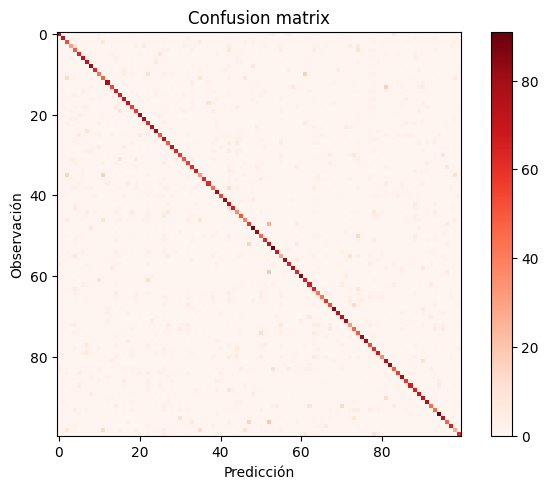

In [46]:
from sklearn.metrics import confusion_matrix
from numpy import argmax
###############################################################################
# confussion matrix
###############################################################################
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')
Y_pred = model.predict(test_images)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(100))


Observando la matriz de confusión, se identifican patrones notables en el rendimiento del modelo. Aunque la diagonal representa predicciones correctas, se observan líneas verticales destacadas. Estas líneas indican que el modelo tiende a clasificar muchas imágenes en ciertas clases específicas.

Por ejemplo, se notan muchas predicciones incorrectas para las clases 22 y 39, entre otras. Además, hay clases, como la 27 y 63, que el modelo nunca predice.








In [49]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, Y_pred_classes, target_names=classes, digits=5))

                   precision    recall  f1-score   support

           beaver    0.92593   0.75000   0.82873       100
          dolphin    0.80000   0.72000   0.75789       100
            otter    0.46903   0.53000   0.49765       100
             seal    0.48438   0.31000   0.37805       100
            whale    0.36296   0.49000   0.41702       100
         aquarium    0.64000   0.64000   0.64000       100
             fish    0.62281   0.71000   0.66355       100
              ray    0.52174   0.72000   0.60504       100
            shark    0.67769   0.82000   0.74208       100
            trout    0.85135   0.63000   0.72414       100
          orchids    0.51807   0.43000   0.46995       100
          poppies    0.42342   0.47000   0.44550       100
            roses    0.75728   0.78000   0.76847       100
       sunflowers    0.62069   0.54000   0.57754       100
           tulips    0.51163   0.66000   0.57642       100
          bottles    0.56410   0.66000   0.60829       

La tabla de evaluación del modelo proporciona métricas clave para cada clase, revelando su rendimiento en términos de precisión, recall y F1-score. A continuación, algunas observaciones y consideraciones:

***Precision, Recall y F1-Score:*** Estas métricas ofrecen una visión integral del rendimiento del modelo para cada clase. La precisión indica la proporción de predicciones correctas en relación con las etiquetas predichas positivas, mientras que el recall mide la proporción de predicciones correctas en relación con todas las etiquetas verdaderamente positivas. El F1-score es la media armónica entre precisión y recall, proporcionando una métrica equilibrada.

***Patrones de Clasificación:*** Se observa que algunas clases, como "beaver," "whale," y "shark," muestran buen rendimiento con altos valores de precisión, recall y F1-score. Sin embargo, otras clases, como "otter," "seal," y "fish," tienen puntuaciones más bajas, lo que indica dificultades en la clasificación de esas categorías.

***Tendencias de Clasificación***: Algunas clases muestran tendencias de clasificación similares, con precisiones y recalls cercanos. Por ejemplo, "clock" y "television" comparten patrones de rendimiento. Estas observaciones pueden sugerir características visuales o desafíos específicos compartidos entre ciertos grupos de clases.

***Precision vs. Recall***: En algunas clases, como "apples," "mushrooms," y "plain," la precisión es más alta que el recall, indicando que el modelo puede ser más cauteloso al predecir estas clases y tiende a ser más preciso cuando lo hace.

***Desafíos Específicos***: Clases como "girl," "lion," y "tank" presentan desafíos particulares con valores de precisión, recall y F1-score más bajos. Estos casos pueden requerir enfoques específicos de mejora, como técnicas de aumento de datos, ajustes arquitectónicos o mayor complejidad en el modelo.

313/313 [==============================] - 1s 3ms/step


========================== IMAGEN Nº4831 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[1.1867406e-09 9.8491727e-12 5.3372809e-05 1.3993580e-12 1.8684583e-13
 6.6358785e-10 1.7428791e-11 7.1338536e-07 1.8954992e-08 5.8786514e-05
 5.5918550e-01 3.9724210e-07 8.8202835e-14 1.0528432e-08 3.4524599e-06
 1.9594370e-11 3.0414221e-01 2.9745234e-12 6.2495960e-09 5.0621819e-15
 1.2937755e-11 6.9870552e-08 1.1039983e-01 3.2376379e-09 1.1164036e-09
 4.9057924e-10 8.8213827e-09 1.0163873e-11 5.4978204e-07 7.5244162e-13
 3.6673477e-12 5.0551896e-10 7.1932110e-10 2.7283771e-13 6.5519748e-15
 3.9310735e-06 2.4793118e-13 5.6063054e-12 7.3360448e-15 5.3250606e-08
 1.4871328e-09 6.3287609e-07 6.5574508e-15 2.0798792e-14 1.6207144e-10
 4.2548698e-05 1.7687948e-09 2.9158557e-12 3.7248302e-08 3.1117850e-08
 7.5448731e-15 2.2175090e-08 6.3541329e-12 2.8236300e-07 3.6326261e-10
 1.2467774e-11 3.6416253e-13 1.3736642e-

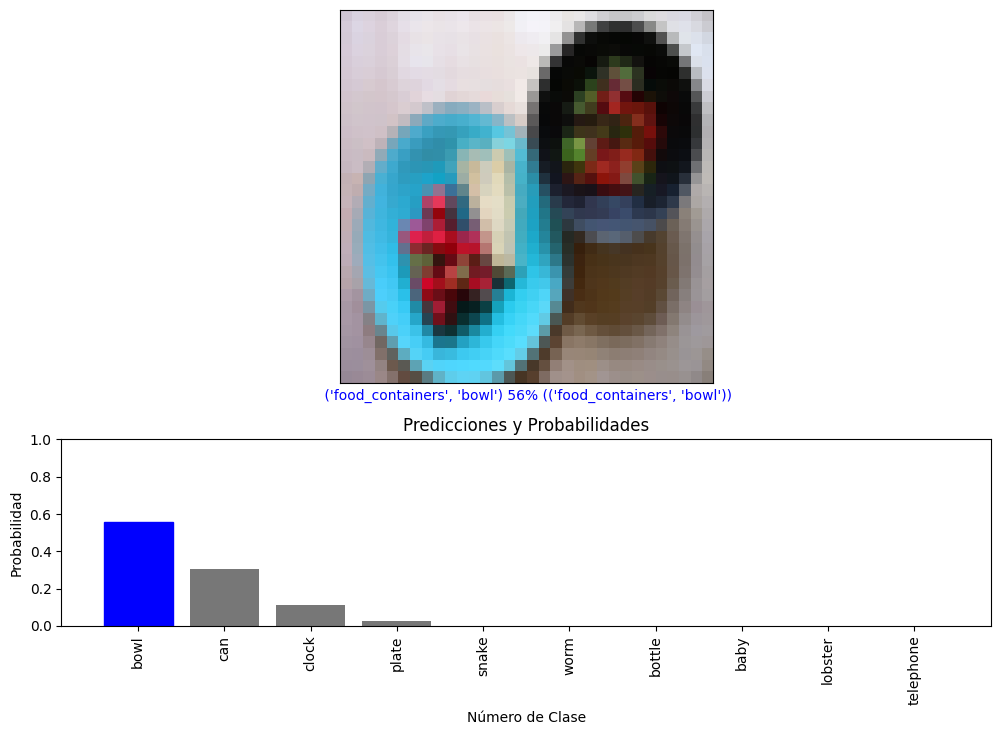

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº8968 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[1.66195289e-08 3.70783055e-05 1.99645961e-04 6.10239757e-03
 5.99373889e-05 3.51511108e-06 2.48251563e-05 1.54368706e-07
 7.75974477e-05 2.30067599e-06 7.47961212e-06 1.96007910e-04
 5.88029041e-04 2.47899879e-06 1.14762506e-05 1.81165792e-03
 2.58566888e-06 1.46727973e-06 2.41852626e-06 2.62379274e-03
 7.69956685e-08 4.32870229e-06 7.82520829e-07 3.16120548e-07
 1.24855808e-06 1.92557854e-06 3.44606264e-07 2.60132772e-04
 6.55996928e-06 3.92178335e-04 1.11656605e-04 3.18915962e-04
 9.61803653e-06 5.18548450e-06 1.12317107e-03 6.49216236e-04
 2.16594963e-05 1.04105966e-04 1.45316694e-03 9.88414399e-07
 1.70015994e-06 8.03854221e-07 3.18050802e-01 1.79831381e-03
 1.55688016e-04 1.06523594e-07 2.83580477e-04 1.60583610e-07
 4.34081448e-06 7.66766971e-06 9.43876003e-05 1.06242029e-02
 7.83868970e-09 3.87457931e-07 3.39741237e-05 1.95047318e-03
 1.86558268e-07 1.0169

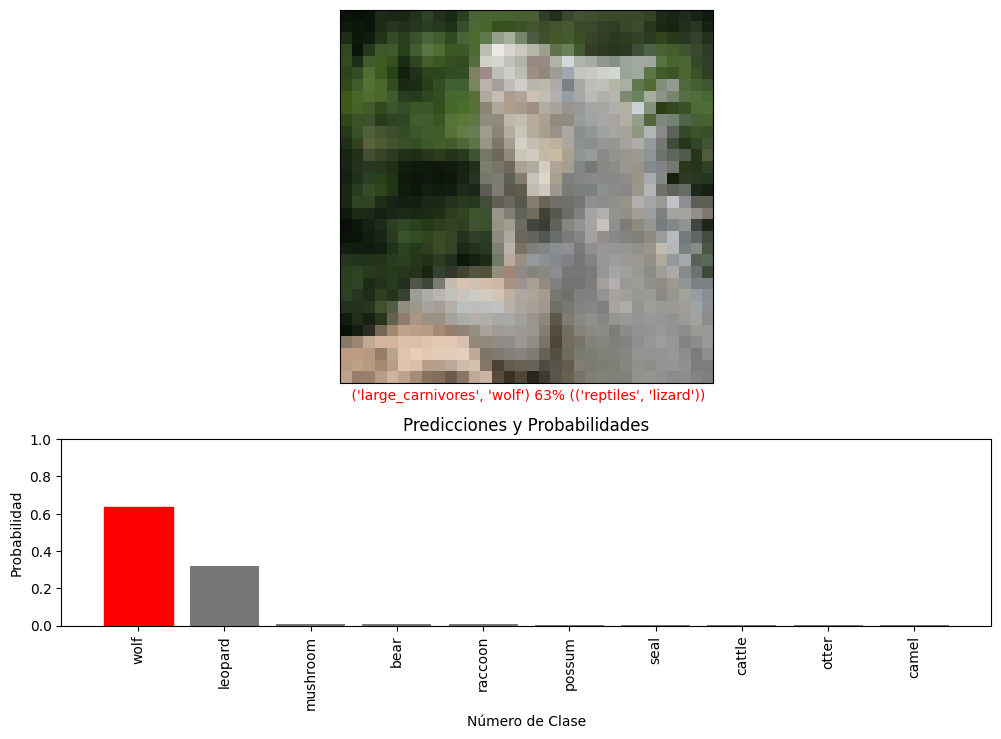

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº9733 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[2.83048194e-05 8.47394331e-05 4.14318629e-06 5.49579188e-02
 9.67390777e-04 1.49021271e-05 7.88974194e-06 1.15820549e-04
 9.47110821e-05 1.12552567e-04 3.68762958e-05 1.02112870e-06
 2.20740680e-03 2.19897297e-03 1.42430117e-05 1.25753911e-06
 3.61783430e-04 5.44312279e-05 1.01805126e-04 2.48065796e-02
 6.52716335e-05 1.22679980e-04 9.75823728e-04 5.72271412e-04
 5.86683054e-05 6.95305169e-02 1.17594700e-05 7.91249040e-04
 1.74195266e-05 8.46656039e-05 5.23859017e-05 1.26541781e-04
 1.33563972e-05 2.80889450e-03 5.56937857e-06 1.70947769e-05
 6.50062839e-06 9.74984596e-06 1.23377598e-04 2.07006364e-04
 1.04893069e-03 6.56689881e-05 2.35550608e-02 7.99697318e-07
 2.80846580e-05 1.49782466e-06 5.25918331e-05 1.46494407e-04
 5.94633911e-03 1.26928235e-05 1.37712177e-05 1.09100956e-05
 3.63838684e-04 3.79509147e-05 1.95221965e-05 1.23498859e-04
 2.09214909e-06 1.5155

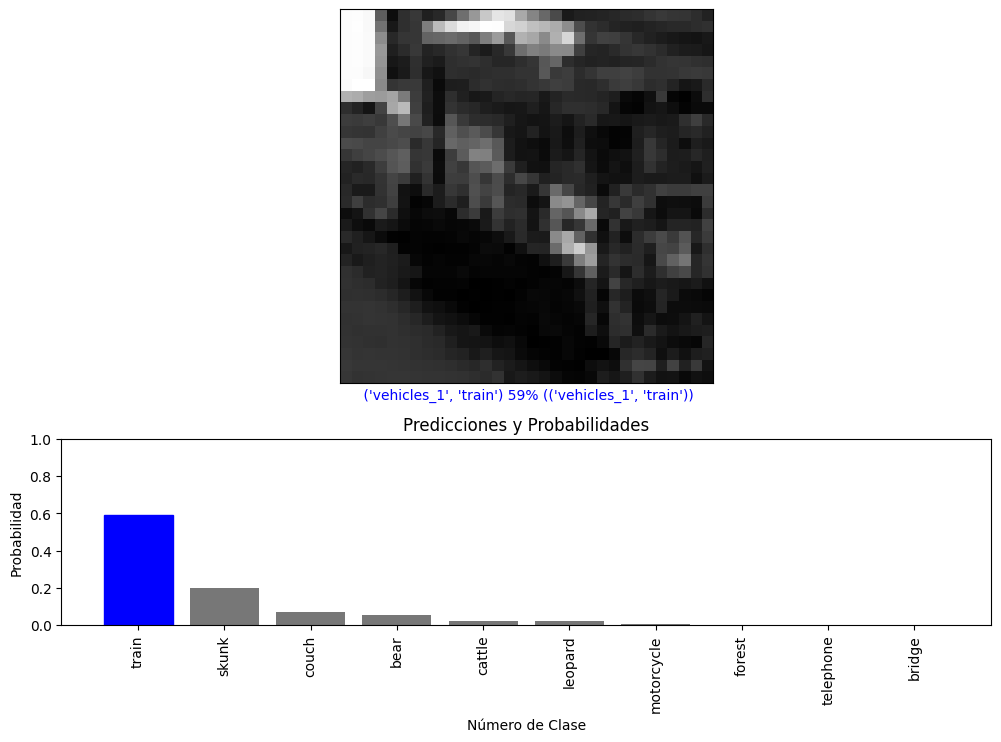

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº5881 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[5.48885604e-10 2.66548849e-11 5.41598710e-10 8.21978574e-09
 7.53596829e-09 1.43932357e-06 3.60570054e-13 1.35648015e-09
 1.50496177e-07 4.73454165e-10 2.34115033e-10 1.43122370e-09
 6.73573377e-05 1.47318843e-07 1.71294211e-11 3.83140453e-08
 2.14135856e-08 9.99825060e-01 2.57417504e-10 4.60779006e-08
 4.70110451e-10 1.55131269e-10 7.12623072e-10 4.49490827e-08
 6.51374996e-11 2.98642320e-08 1.71244005e-10 7.46221076e-08
 6.14598428e-10 1.50520929e-08 1.31032893e-10 1.64077150e-07
 6.96422688e-08 3.11403227e-07 2.34144615e-09 4.23502655e-09
 1.70509207e-08 2.82462534e-05 2.58979895e-08 1.37133645e-06
 1.57270534e-08 1.33410385e-08 4.23636629e-06 8.01590114e-11
 1.35454564e-10 6.37313813e-10 6.81134011e-08 5.57696556e-09
 1.94279490e-08 3.05359499e-05 5.28507904e-10 2.98703706e-09
 5.19786747e-09 5.09508880e-08 6.13391907e-11 1.89067624e-08
 3.63866076e-10 4.2276

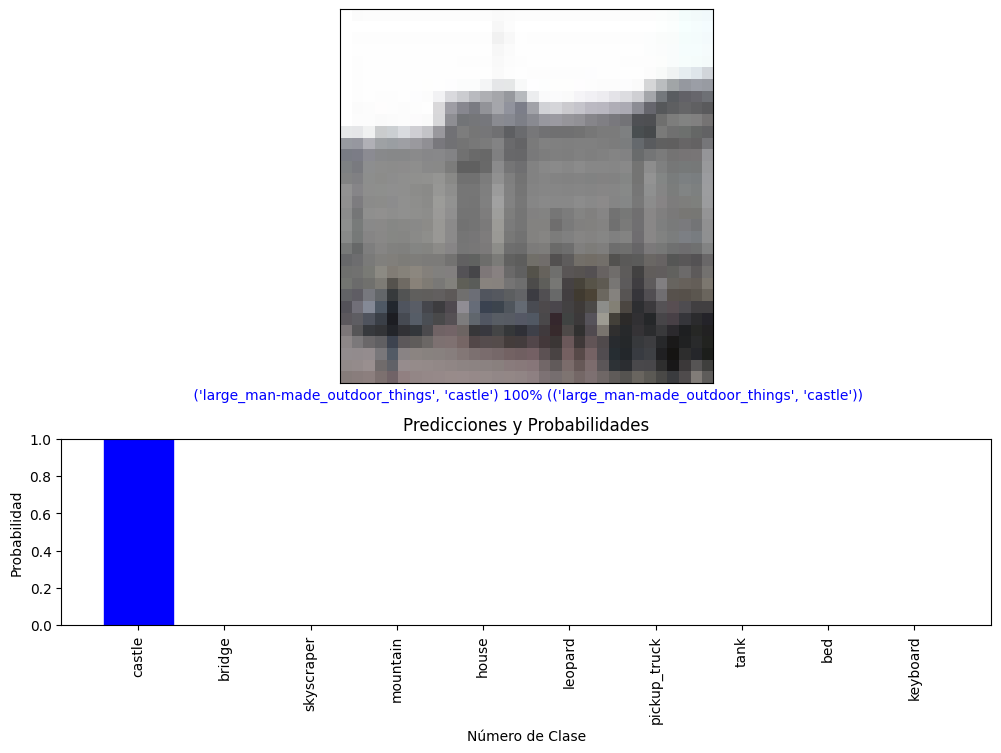

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº4055 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[3.39686521e-03 5.79877860e-06 1.04146193e-06 1.26641930e-06
 2.89231394e-07 7.81871586e-06 6.41325641e-07 1.76523772e-05
 4.74600938e-06 3.30260627e-05 2.87544644e-05 1.39340727e-07
 1.21757944e-06 1.10846861e-06 4.24097408e-07 2.94385160e-07
 1.28139029e-04 1.29089528e-07 2.08820263e-03 3.39340113e-05
 9.74780505e-06 8.49874127e-08 1.52488819e-05 8.45685368e-04
 1.31040841e-04 1.62953547e-05 2.53072008e-04 2.06784207e-05
 9.43770792e-05 3.51127892e-06 3.10263886e-07 6.28568159e-05
 4.30254005e-02 3.62250248e-05 1.16065803e-05 8.45697798e-07
 4.58106024e-06 5.46954091e-08 9.02106058e-06 3.01018037e-04
 4.41750899e-07 2.26130403e-04 5.75469755e-07 1.33977574e-06
 4.11340698e-05 2.05373908e-05 9.69465574e-08 1.33752621e-06
 1.95355042e-07 5.75198719e-05 5.20013127e-05 4.45318983e-06
 5.79883363e-06 1.94974882e-06 9.96184895e-07 4.37960989e-04
 1.81418036e-05 7.9543

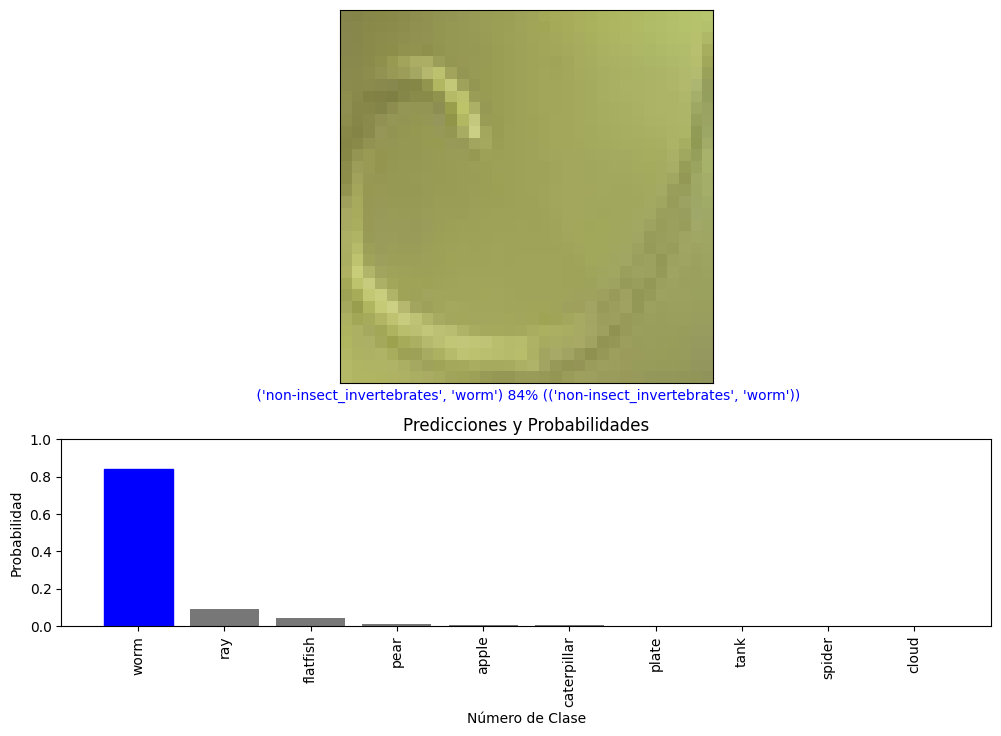

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº3283 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[8.63669580e-10 2.73927760e-08 2.61932565e-09 6.92040258e-10
 1.70240586e-10 1.73211220e-11 5.95540848e-12 5.35208642e-08
 5.56065570e-05 3.72720521e-08 5.96497302e-05 2.04572270e-09
 3.17488674e-11 1.01742637e-09 1.91975733e-08 3.42480239e-10
 4.49958694e-04 7.27595230e-13 1.27498119e-08 5.01761393e-13
 1.77924719e-09 1.75761397e-08 9.83216882e-01 1.57990776e-09
 1.54424407e-11 3.03124659e-09 1.90168862e-06 2.56627857e-07
 5.67634004e-07 2.52839472e-10 1.18111743e-10 1.86522575e-09
 1.52265591e-06 5.26998944e-10 6.16942261e-11 3.61142505e-10
 2.47278731e-08 2.27932018e-12 2.98767988e-09 1.38301648e-05
 2.67262476e-06 2.99536055e-07 2.68034821e-08 3.44607543e-08
 5.46616832e-08 4.77943773e-09 3.40399042e-09 3.20748844e-10
 1.56560560e-08 9.63856564e-11 7.95687001e-08 2.96440732e-07
 2.37568969e-08 8.57534772e-08 9.41356021e-12 1.90662064e-08
 2.86391987e-11 6.3101

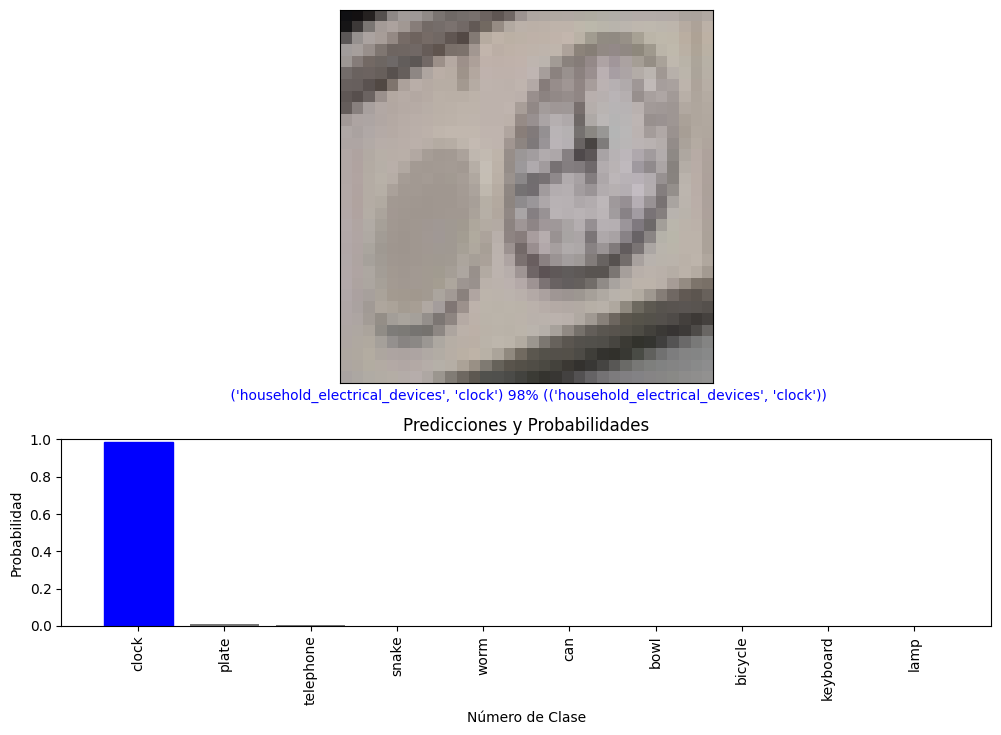

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº7127 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[2.22748523e-14 3.50795434e-12 3.77633654e-11 2.36988311e-11
 4.37112083e-11 9.99938846e-01 1.71823875e-11 1.87093577e-10
 3.03556854e-12 8.02670264e-10 2.39960194e-08 2.14157875e-11
 2.91330682e-10 1.34841294e-09 5.94463678e-08 9.05262643e-10
 2.79425933e-07 1.33447441e-12 6.20482277e-11 1.27988464e-09
 6.19043567e-06 3.91961908e-13 6.49456669e-11 9.93981373e-12
 2.37621069e-11 2.67947453e-05 3.55261653e-12 2.17909510e-11
 2.98191205e-09 1.37790321e-10 4.28161569e-11 2.02006123e-13
 2.02675849e-08 1.36478968e-12 1.74077837e-08 3.10534688e-11
 1.26913513e-09 1.08242165e-11 1.93109889e-10 6.83796486e-09
 1.12860334e-08 1.58452740e-09 4.44951738e-08 2.13409637e-11
 1.95284695e-08 1.17895797e-11 1.46319293e-11 1.58071646e-11
 2.84551289e-12 5.53997169e-13 7.24310278e-10 6.40606723e-09
 3.01015940e-12 2.26441949e-10 1.41026718e-10 1.07710257e-10
 1.21746536e-12 1.0742

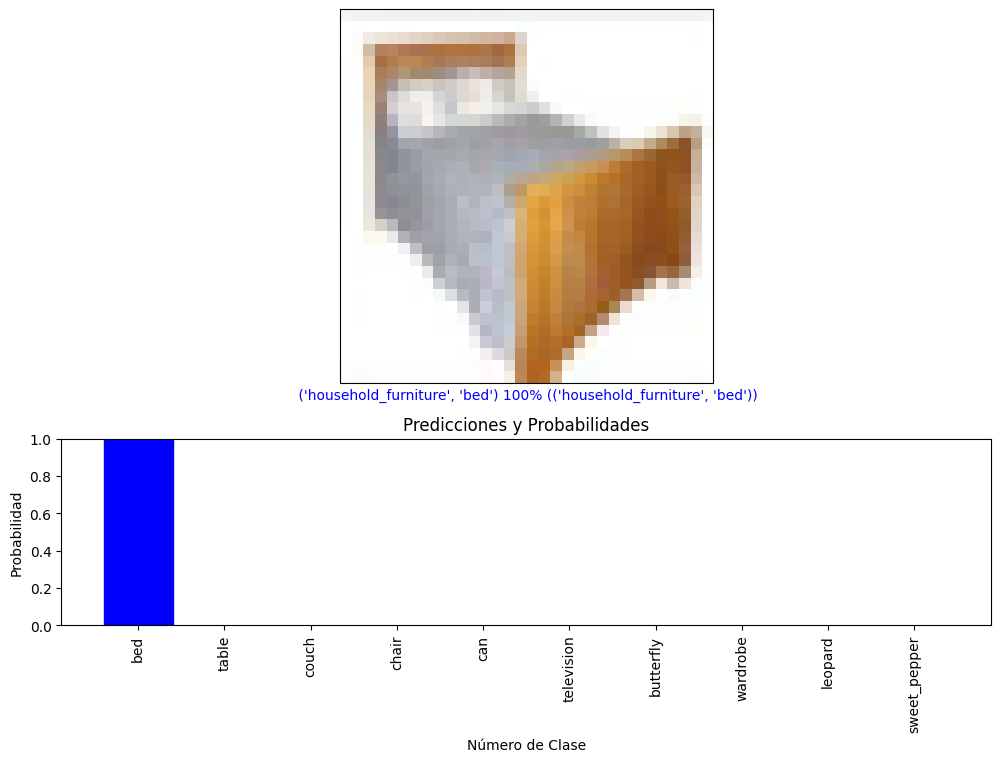

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº2566 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[1.91580662e-09 3.24749699e-10 2.58889088e-08 3.08100507e-12
 2.40028115e-12 3.95801817e-06 1.23248445e-09 3.08408204e-07
 1.46270940e-10 2.76638129e-05 1.18659251e-08 3.96547772e-09
 7.73592093e-11 1.44247947e-09 1.66985021e-08 1.24549893e-12
 9.71173227e-01 1.18326282e-09 2.28440378e-09 8.63606062e-13
 1.09686411e-08 2.26402960e-07 2.89519026e-04 6.60814052e-08
 3.92596377e-07 2.67230712e-06 1.36857123e-11 1.33464160e-11
 7.67774733e-09 2.84621298e-14 6.49589453e-12 6.11900342e-13
 1.22594962e-10 5.41594113e-12 5.32308809e-14 1.56654725e-08
 4.77416631e-12 3.37541506e-09 6.10714550e-13 2.50764970e-05
 3.41872948e-07 1.05312971e-07 5.23280551e-12 2.87465832e-11
 2.01157563e-11 2.38731646e-10 3.14303179e-08 1.47355528e-09
 2.66268414e-11 3.43058332e-10 6.30032571e-12 1.87328495e-12
 3.56835811e-10 7.18221982e-10 1.37030031e-11 6.69107348e-12
 1.33740213e-10 4.6208

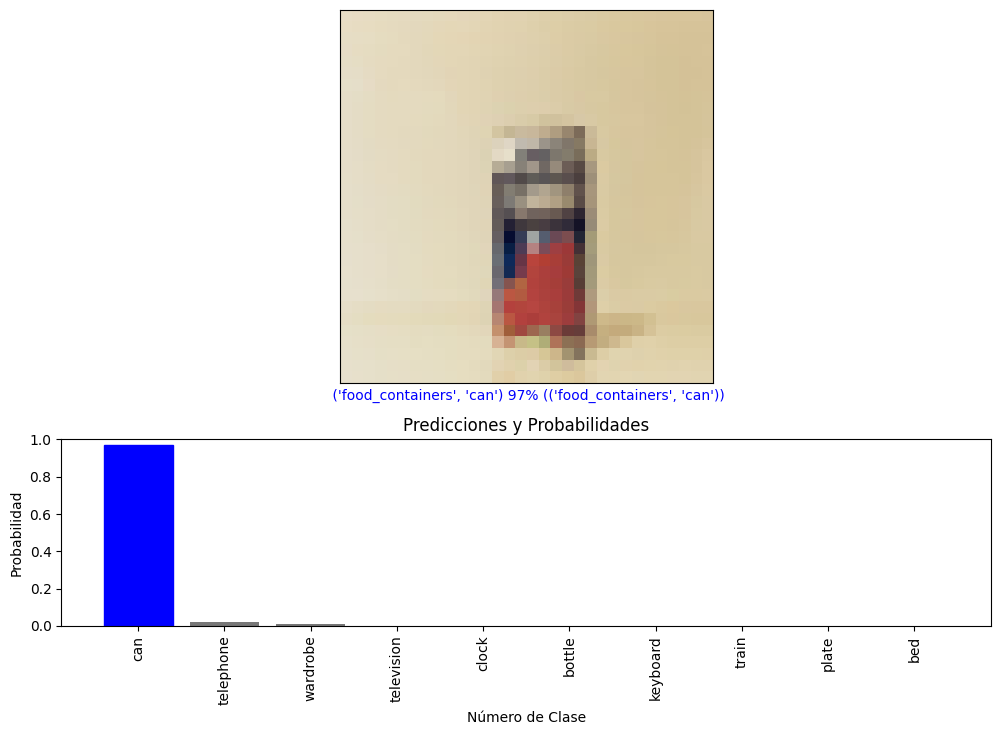

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº8179 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[1.75644254e-06 1.46632068e-04 3.87379713e-02 5.55442909e-08
 8.50149036e-08 2.02984054e-04 7.85334976e-07 9.95750327e-08
 3.47460760e-03 4.74385852e-05 2.39246726e-01 2.76629115e-04
 1.01967643e-08 4.63527540e-05 1.82057003e-04 4.57460807e-08
 1.97274312e-01 1.98542853e-06 1.60906700e-06 1.00453432e-08
 1.64011396e-07 9.98052485e-09 5.62539732e-04 3.24247890e-06
 5.63931657e-08 2.10927660e-03 1.11842914e-04 7.29972527e-08
 4.67434165e-06 4.27892786e-07 1.16433601e-08 8.75673010e-08
 3.19219253e-05 1.74366105e-02 1.25442073e-10 4.60531264e-05
 2.19321650e-09 6.19394195e-05 1.28550051e-08 2.56636034e-04
 3.35522811e-04 7.86688761e-05 1.01163174e-07 6.28915583e-12
 3.45694872e-07 2.16085631e-02 2.68673307e-06 4.78072837e-03
 1.00239985e-01 6.98910890e-06 6.34592517e-11 4.02355181e-06
 1.63793800e-07 1.20146742e-05 1.09845323e-05 1.54662487e-08
 6.05395030e-07 2.4005

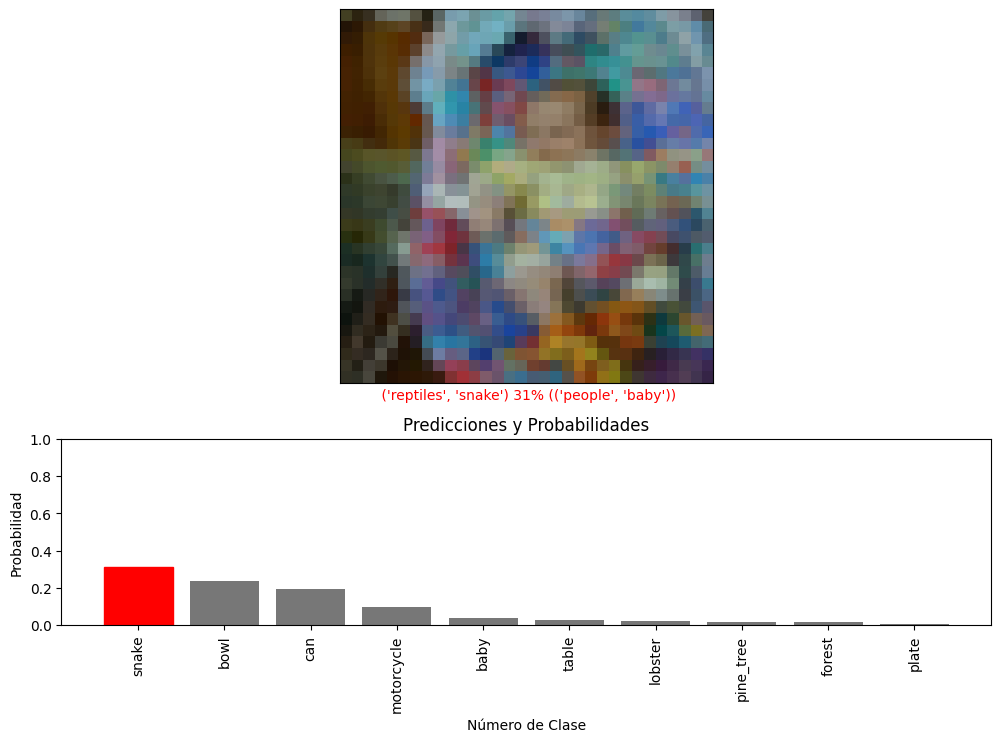

<Figure size 640x480 with 0 Axes>



========================== IMAGEN Nº9314 ===========================

LA LISTA DE PROBABILIDADES DE SER CADA ELEMENTO ES:
[6.26303176e-11 4.03359334e-12 1.13770236e-10 8.23518818e-08
 1.83606758e-07 1.82120328e-08 2.33707894e-07 3.79489023e-07
 2.92290081e-09 1.09085442e-10 1.24881998e-08 5.56679963e-12
 1.99911732e-08 8.93639474e-09 3.91446786e-09 9.92985818e-08
 3.22900352e-11 9.19471631e-07 7.94425237e-09 2.05352393e-08
 3.11576931e-10 5.52520385e-09 1.93630321e-08 2.63465449e-09
 6.27639878e-08 2.86673931e-05 8.54857376e-07 7.83257263e-08
 4.19122029e-11 4.22885569e-06 4.96537815e-13 2.46381870e-09
 3.74407243e-08 1.91513391e-06 7.67242259e-12 3.15297484e-12
 1.78596166e-11 8.76183179e-08 1.74224302e-10 3.86833188e-09
 1.19565857e-10 1.18851176e-07 7.05690354e-07 3.04616957e-11
 4.73802220e-10 2.16246121e-07 3.22843996e-09 1.46036188e-03
 1.38409844e-08 1.75981558e-08 5.42378017e-11 1.07202737e-07
 1.50185488e-02 1.66440250e-09 3.36100245e-11 1.67230052e-09
 4.57527456e-08 7.0048

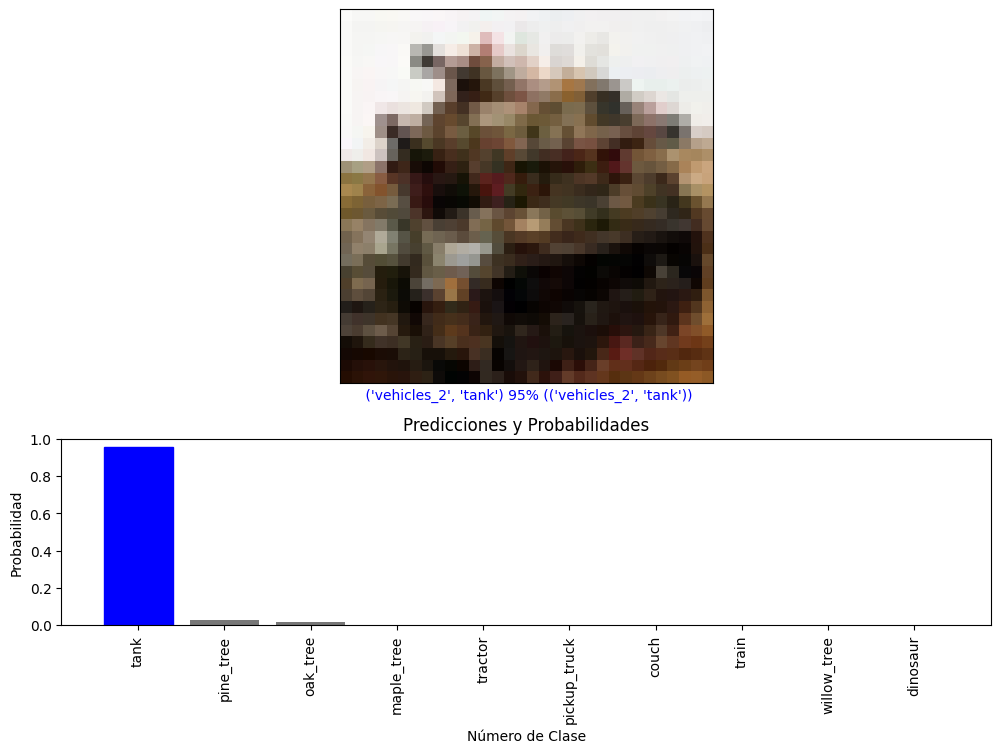

<Figure size 640x480 with 0 Axes>

In [51]:
predictions = model.predict(test_images)
# Obtén índices aleatorios del conjunto de datos de prueba
indices_aleatorios = random.sample(range(len(test_images)), 10)

for k, indice in enumerate(indices_aleatorios):
    print("\n\n=================================================================")
    print(f"========================== IMAGEN Nº{indice+1} ===========================")

    # Predicciones
    predicciones(predictions, indice)

    # Crear la figura con una cuadrícula personalizada de 2 filas y 2 columnas
    plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

    # Subgráfico 1: Mostrar la imagen y la etiqueta
    ax0 = plt.subplot(gs[0, :])
    plot_image(indice, predictions, test_labels, test_images)

    # Subgráfico 2: Mostrar el array de valores
    test_labels2 = test_labels
    ax1 = plt.subplot(gs[1, :])
    plot_value_array(predictions, indice, obtener_superclase_y_clase,test_labels2)

    # Ajustar el diseño de los subgráficos
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

# **4. CONCLUSIÓN.**

Durante el desarrollo de nuestro modelo avanzado, nos enfrentamos a desafíos significativos en la búsqueda de una mayor precisión.
Uno de los principales obstáculos fue la complejidad asociada con la ampliación del conjunto de datos de imágenes.
A pesar de nuestra intención, la tarea de aumentar el tamaño del conjunto de datos se vio obstaculizada por problemas de recursos de memoria, especialmente con respecto a la RAM.

La ampliación de imágenes es una estrategia crucial para mejorar la capacidad de generalización de los modelos de aprendizaje profundo.

Sin embargo, la realización práctica de esta tarea resulto ser problemática, ya que requirió grandes cantidades de memoria.

El modelo final resultante tiene una precisión buena y creemos que si no se amplian las imágenes el límite de precisión es el que hemos obtenido.

#**5. TRABAJO EN EQUIPO**

Cada miembro del equipo se encargó de la creación de modelos. Esta descentralización de la tarea no solo permitió una mayor exploración y experimentación, sino que también nos dió un ambiente de aprendizaje constante. Cuando algún miembro del equipo lograba avances significativos, compartía sus descubrimientos y conocimientos con los demás, creando así una sinergia que impulsó nuestro progreso general.